# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake


# Data Card

![Data Card](scr.png)

# Importing Libraries

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [81]:
# load the data
df = pd.read_csv('recipe_site_traffic_2212.csv')
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


# Data Composition

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


#### Column Servings is displayed as object (String) data type but as shown in the datacard this column should be a category

In [83]:
print(df['servings'].unique())
converted = df['servings'].apply(lambda x: x[0])
df['servings'] = converted.astype('category')
print(df['servings'].unique())

['6' '4' '1' '2' '4 as a snack' '6 as a snack']
['6', '4', '1', '2']
Categories (4, object): ['1', '2', '4', '6']


## Dimensions of the data

In [84]:
print(f'the dimensions of the recipe dataset is: {df.shape[0]} rows and {df.shape[1]} columns')

the dimensions of the recipe dataset is: 947 rows and 8 columns


# Addressing Null values

In [85]:
# let us invetigate the null values now!
df.isna().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

# Observation 01:
1. There are 52 recipes where we don't know the calories, carbohydrates, sugar and protein contents of those recipes
2. There are no null values in categories and servings
3. high traffic is the column where we saw 373 null values

#### Let us visualize them first

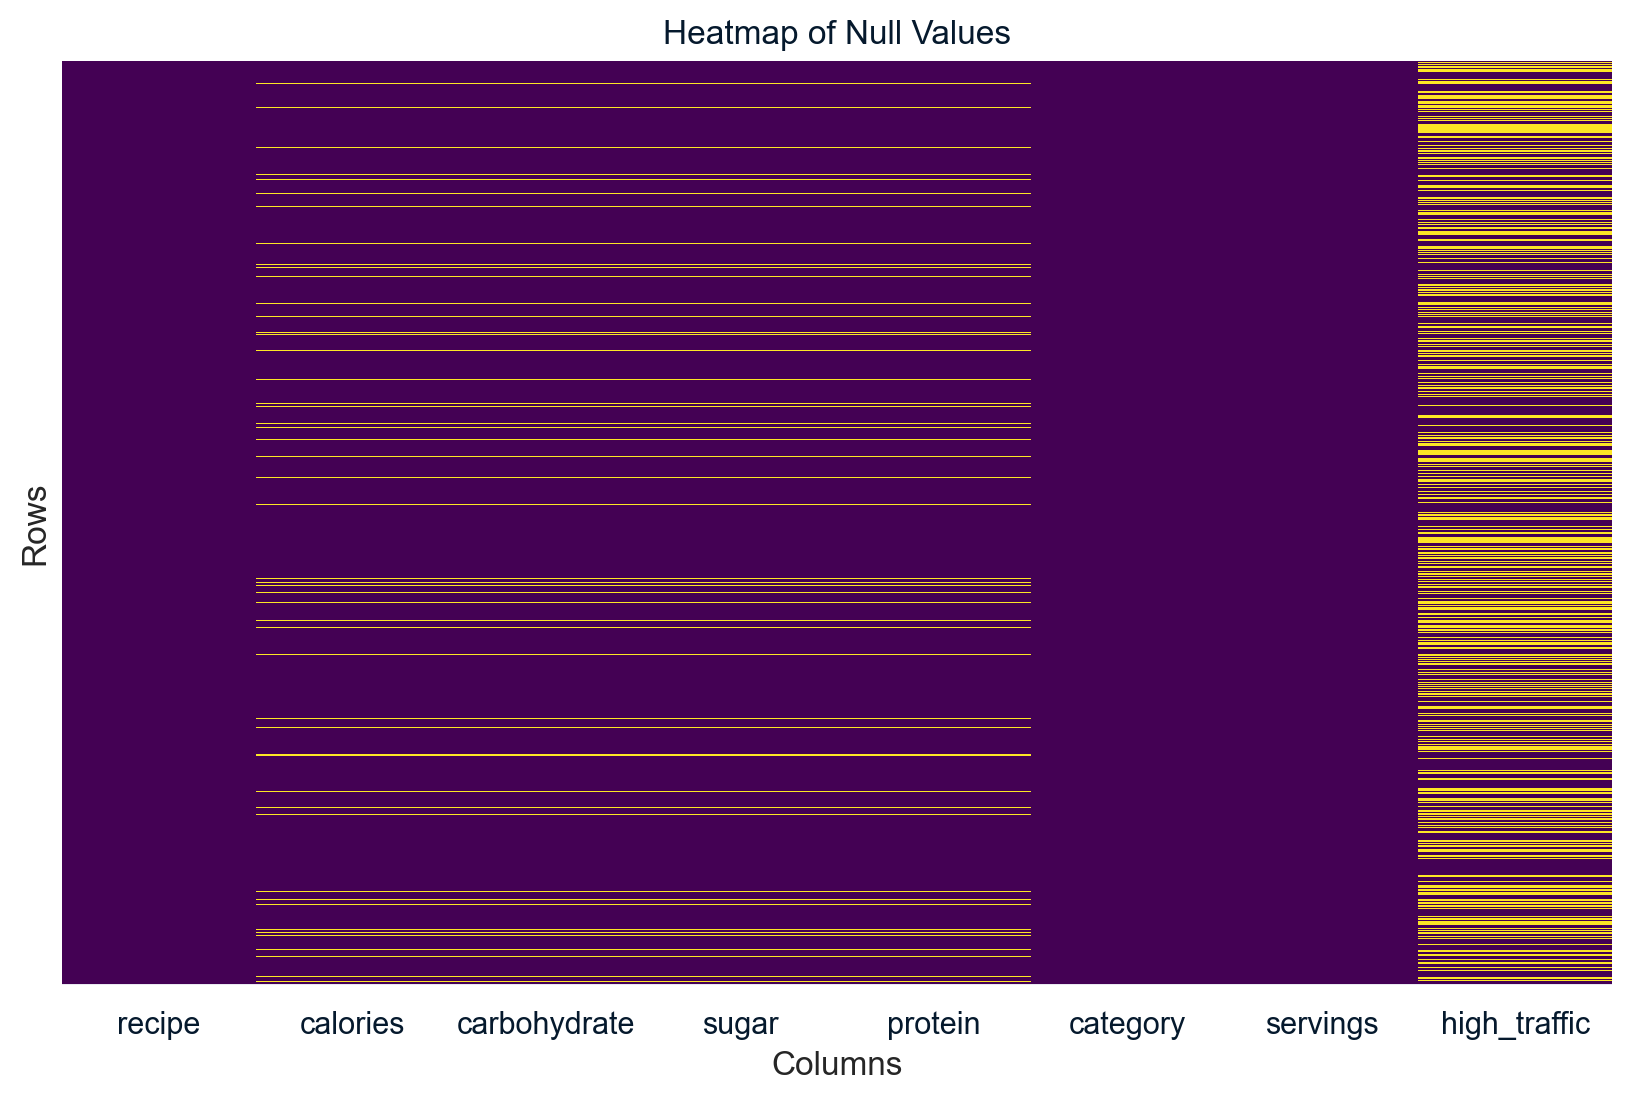

In [86]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('Heatmap of Null Values')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

# Observation 02
1. Alright! so the calories, carbohydrate, sugar and protein value missing in the same row not randomly missing 
2. As the missing values are 5.3% and we have a handful amount of data so its not wise to remove those rows
3. I am thinking of imputing these values with category's median for calories, protein, sugar and carbohydrates (Median because the data is left skewed and has alot of high value outliers so mean is not a good option)

In [87]:
df.groupby('category')[['calories', 'protein', 'sugar', 'carbohydrate']].agg('median')

,calories,protein,sugar,carbohydrate
category,,,,
Beverages,126.455,0.410,8.075,11.250
Breakfast,229.380,11.685,4.830,28.420
Chicken,379.870,32.980,3.170,18.110
Chicken Breast,371.335,37.770,3.645,13.475
Dessert,288.550,4.810,24.650,38.550
Lunch/Snacks,369.505,12.965,2.750,31.985
Meat,460.870,28.530,3.385,19.115
One Dish Meal,419.280,28.480,4.040,25.430
Pork,399.260,29.820,5.230,19.560


In [88]:
# Method to fill null values based on group means

def fill_missing_with_group_median(df, group_col, target_cols):
    for col in target_cols:
        df[col] = df[col].fillna(df.groupby(group_col)[col].transform('median'))
    return df

# Columns to impute
nutrition_columns = ['calories', 'protein', 'sugar', 'carbohydrate']

# Fill missing values
df_filled = fill_missing_with_group_median(df, 'category', nutrition_columns)
df_filled.isna().sum()

# df_droped = df.dropna(subset=nutrition_columns)
# df_droped.isna().sum()

recipe            0
calories          0
carbohydrate      0
sugar             0
protein           0
category          0
servings          0
high_traffic    373
dtype: int64

# Setting Recipe as Index:
#### Looking like the recipe column is unique throughout the dataset, if so we can set it as index

In [89]:
# check recipe column if its unique throughout
df['recipe'].nunique()

947

#### Yes it is unique throughout! We can use it as index

In [90]:
df.set_index('recipe').head(2)

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
1,399.26,19.56,5.23,29.82,Pork,6,High
2,35.48,38.56,0.66,0.92,Potato,4,High


## Investigate 'high_traffic' column 

In [91]:
df = df_filled.copy()
df['high_traffic'].value_counts()

High    574
Name: high_traffic, dtype: int64

#### Out of a total of 574 high-traffic recipes, 373 values are not recorded. Given the context in the datacard, these missing values are intentional. Therefore, we can impute these missing entries with the designation 'Low'.

In [92]:
df['high_traffic'].fillna('Low',inplace=True)

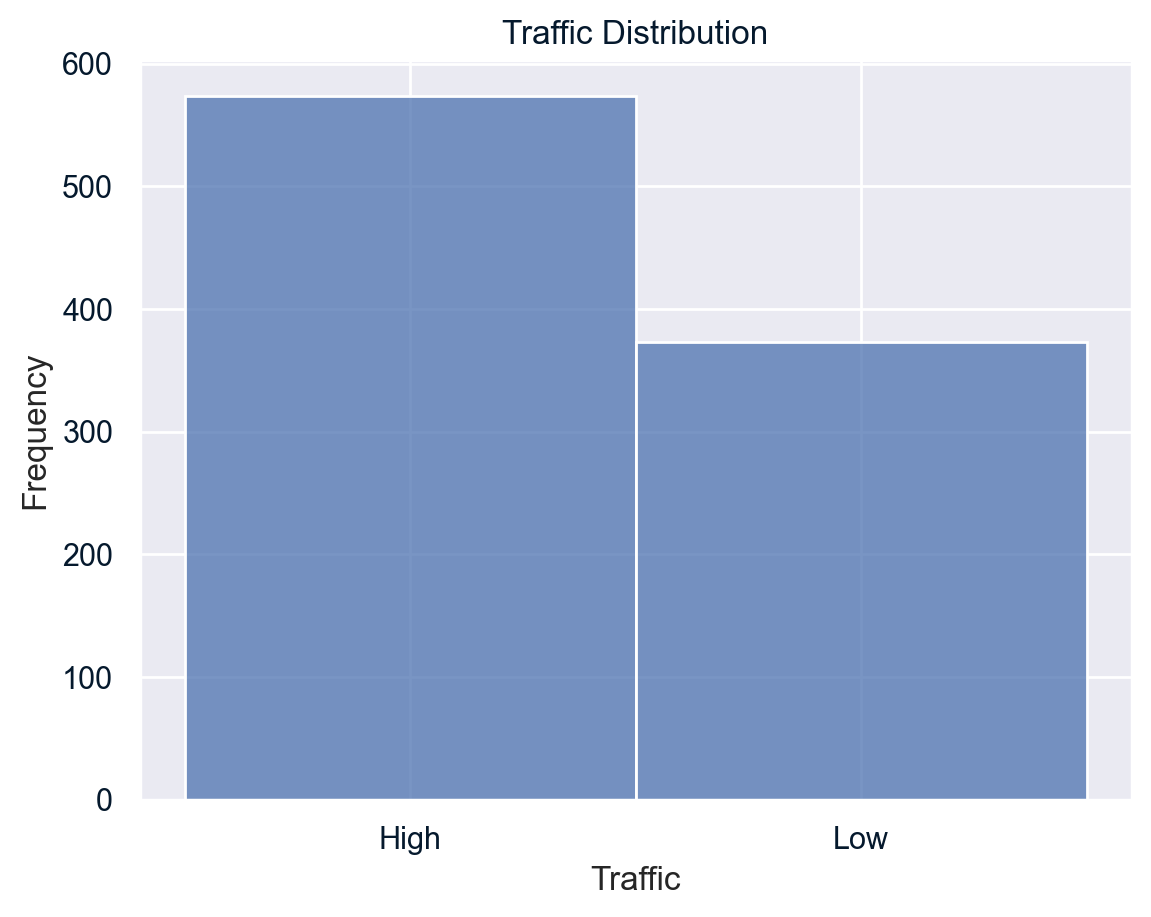

In [93]:
sns.histplot(df['high_traffic'])
plt.xlabel('Traffic')
plt.ylabel('Frequency')
plt.title('Traffic Distribution')
plt.show()

# Observation 03: 
1. Distribution of the target variable with 574 High traffic recipes and 373 low traffic, slightly skewed but we can balance classes during the modeling stage. 

# Duplicate values

In [94]:
# duplicate values
print(f'the total number of duplicates found are: {df.duplicated().sum()}')

the total number of duplicates found are: 0


# Outliers in the data

# Create boxplots for all numeric columns

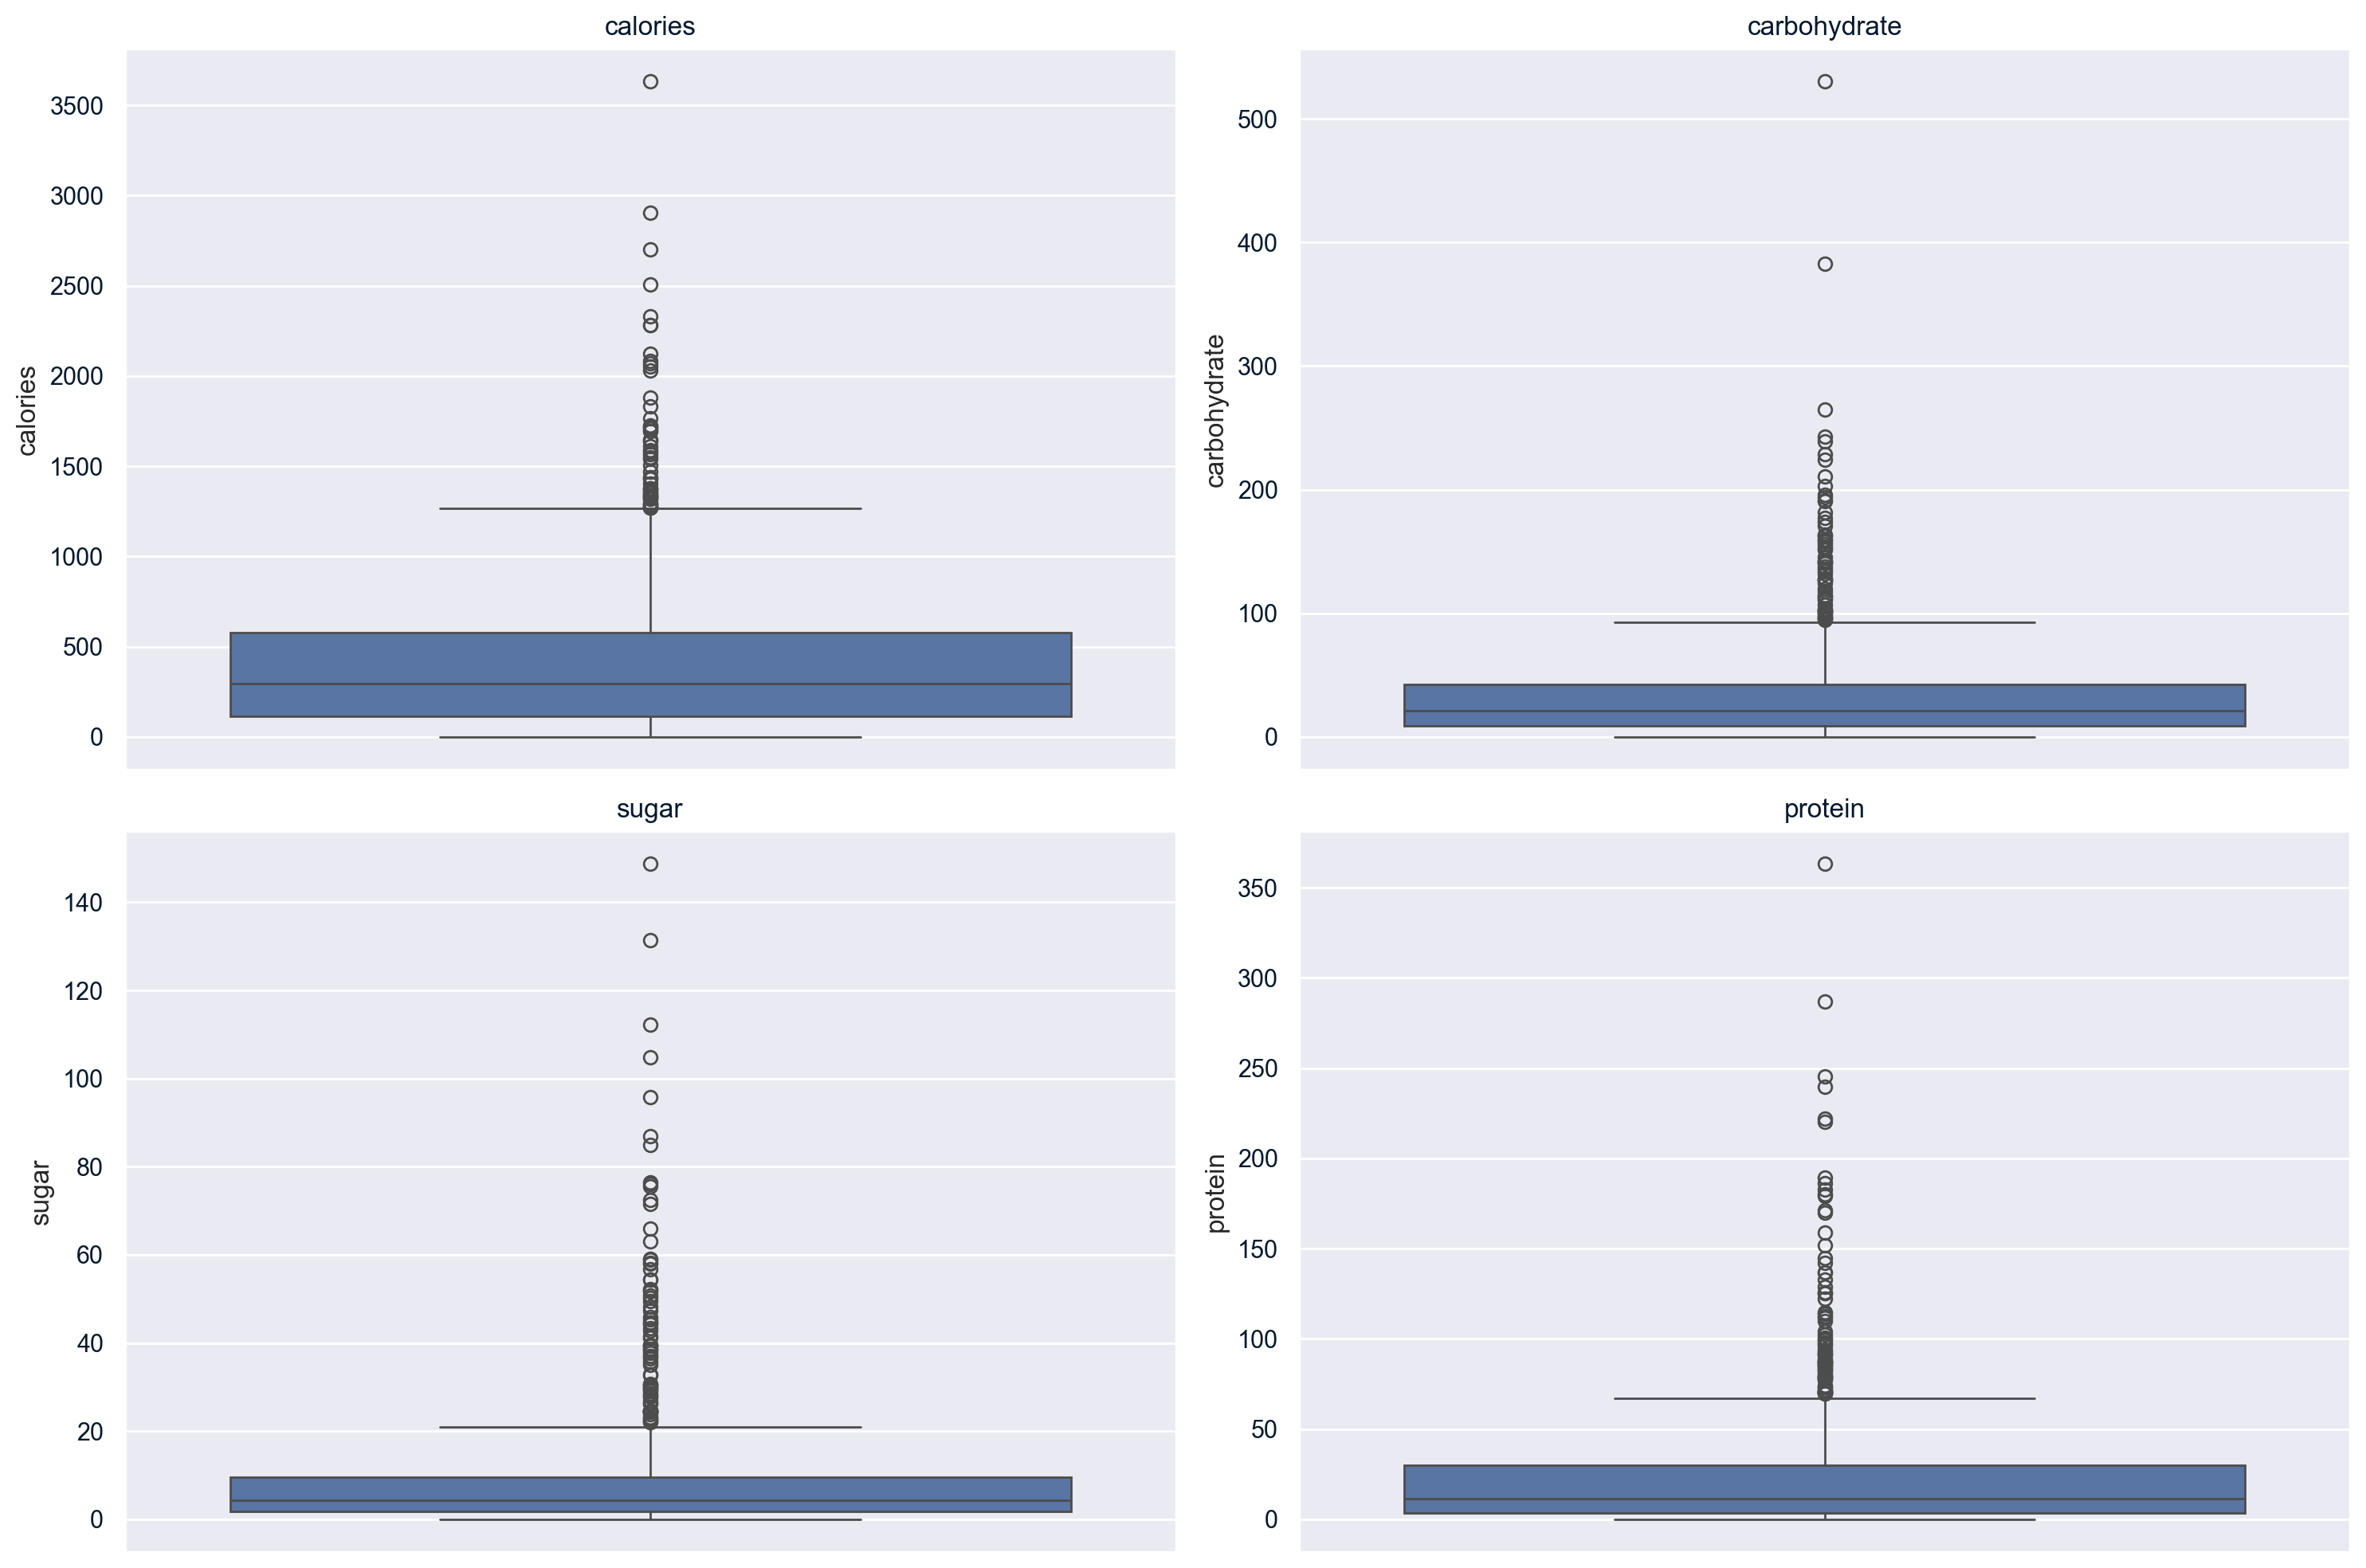

In [95]:
plt.figure(figsize=(15, 10))
data_num = df[['calories', 'carbohydrate', 'sugar', 'protein']]
for i, column in enumerate(data_num.columns):
    plt.subplot(2, 2, i + 1)  # Adjust the number of rows and columns as needed
    sns.boxplot(y=df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

These are some data points that are way above 75th percentile but as these are recipes there can be exceptions but we need to handle these values because they can skew our results and model will underperform.

## Handling Outliers with IQR method

In [96]:
df_before =df.copy()
# Handling Outliers
def handle_outlier(df,col):
    Q3 = df[col].quantile(0.75)
    Q1 = df[col].quantile(0.25)
    IQR = Q3 - Q1
    upper = Q3 + (1.5 * IQR)
    lower = Q1 - (1.5 * IQR)
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])
    
for column in data_num.columns:
    handle_outlier(df, column)

## Comparison of Numerical variables with outliers and without outliers

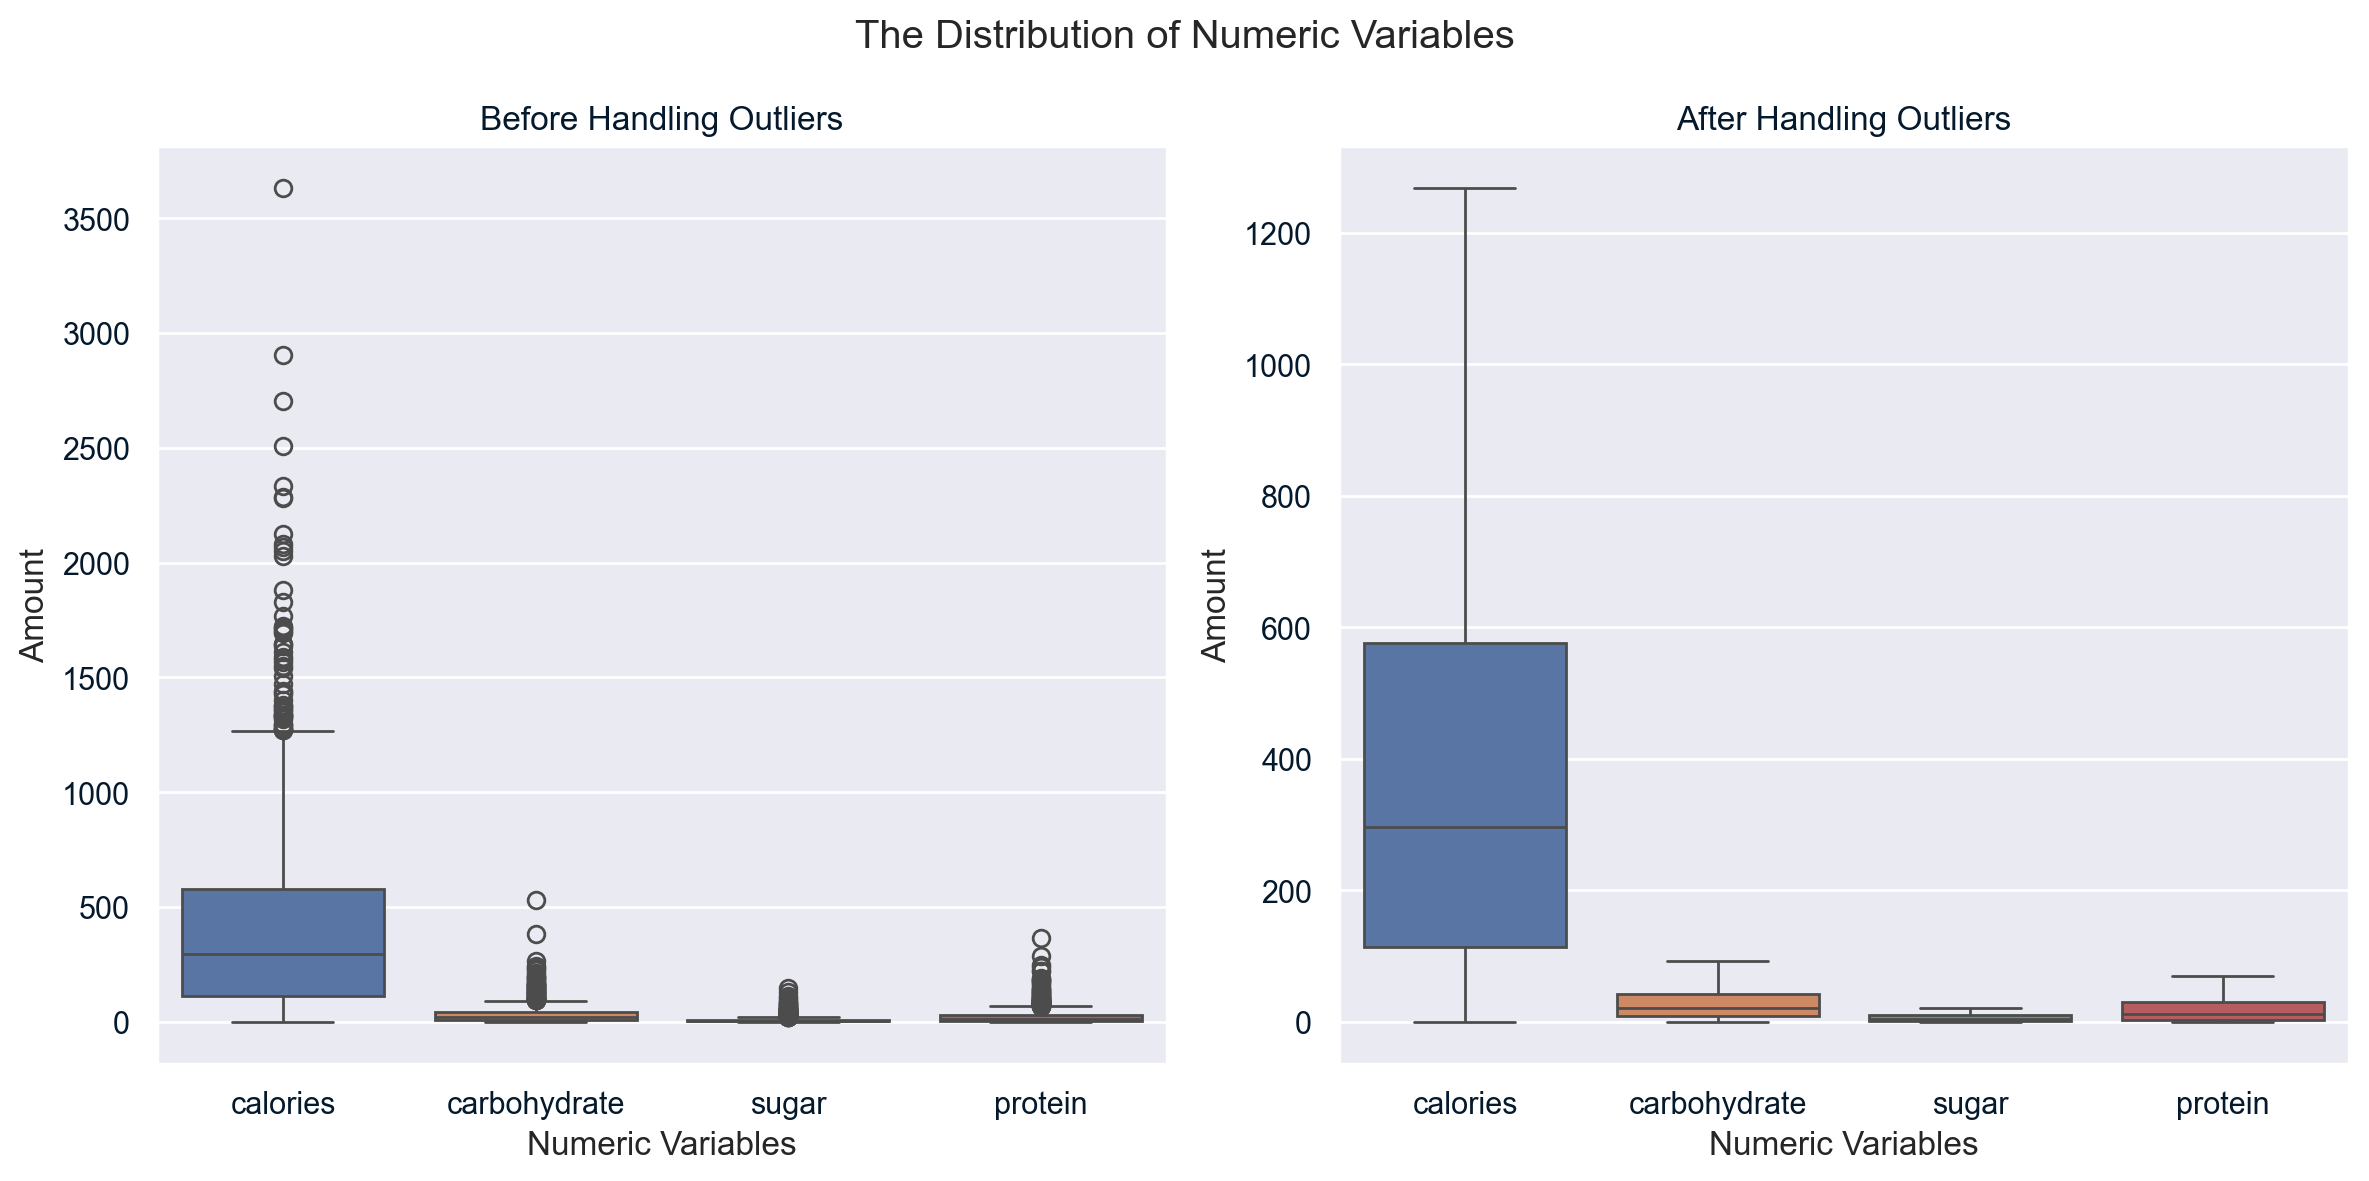

In [97]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(df_before[data_num.columns], ax=axes[0])
sns.boxplot(df[data_num.columns],ax=axes[1])
axes[0].set_title("Before Handling Outliers")
axes[1].set_title("After Handling Outliers")
fig.suptitle("The Distribution of Numeric Variables")
axes[0].set_xlabel("Numeric Variables")
axes[1].set_xlabel("Numeric Variables")
axes[0].set_ylabel("Amount")
axes[1].set_ylabel("Amount")
plt.tight_layout()
plt.show()

## Which Dishes had the most amount of traffic, is there any category predominant?

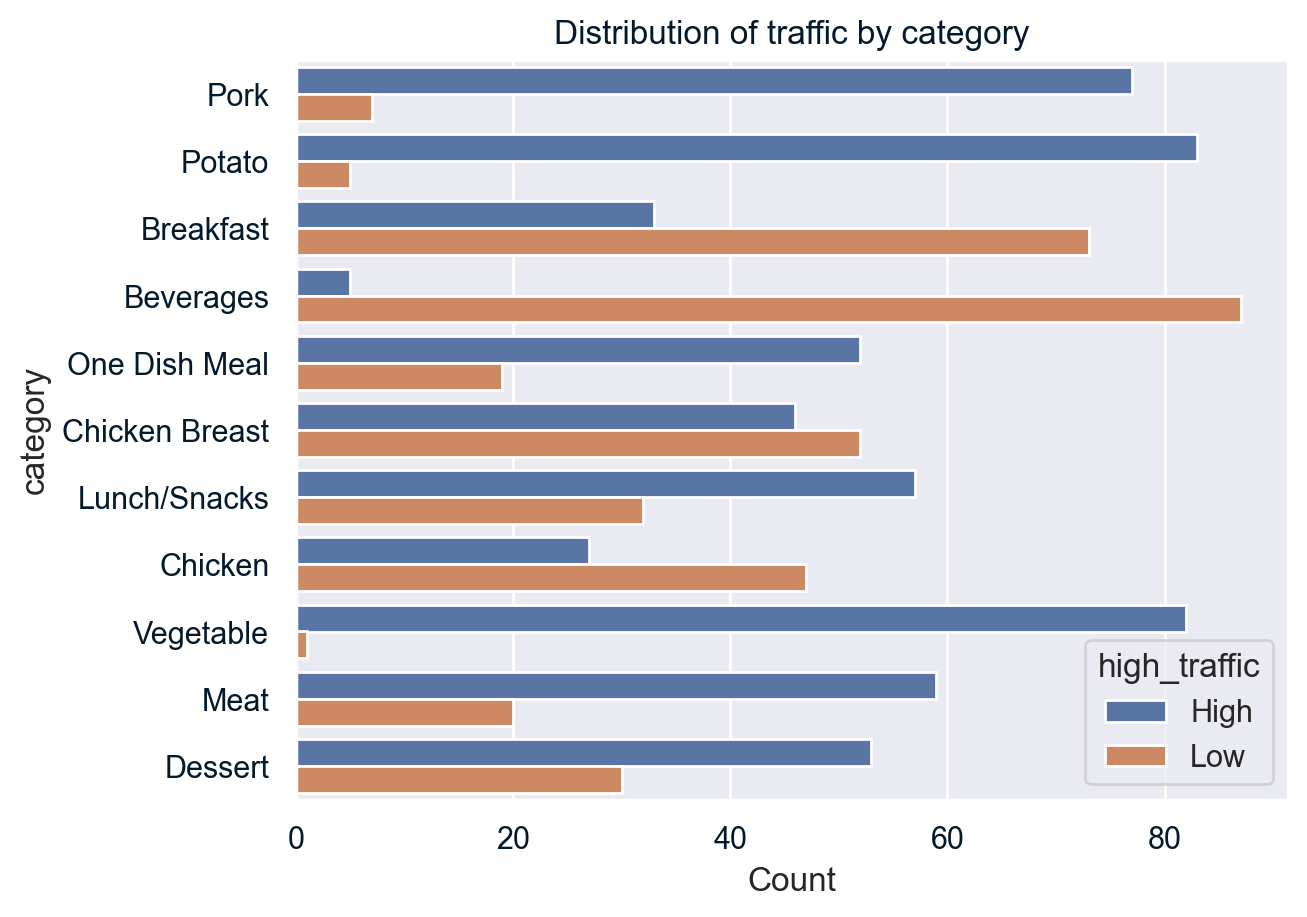

In [98]:
sns.countplot(data=df, y="category", hue="high_traffic")
plt.title('Distribution of traffic by category')
plt.xlabel('Count')
plt.show()

# Obersevation 04:
1. The top 4 recipe categories that received the most amount of traffic are Potato, Vegetable, Pork, Meat and Lunch/Snacks.
2. Where as Chicken Breast, Chicken and Beverages are the least popular recipes.
3. Beverages infact are a total disaster, we are not getting any traffic for them.

# Business Recomendation 01:
1. Craft more recipe's around Potato, Vegetables and Pork to attract more traffic.

## Which recipes are popular when people have to serve 3 or more people?

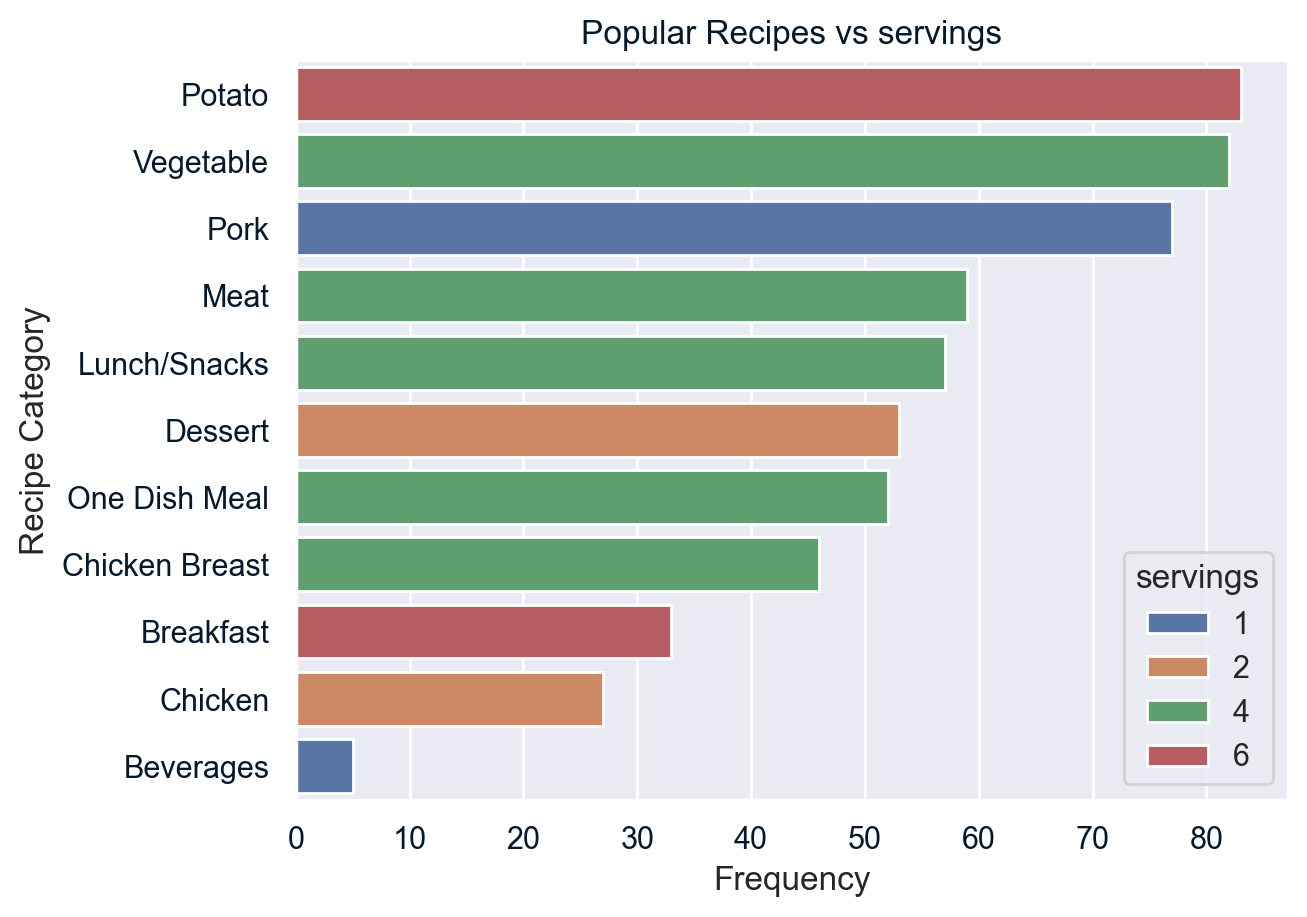

In [99]:
popular_categories = df[df['high_traffic'] == 'High']['category'].value_counts(ascending=False).reset_index()
sns.barplot(data=popular_categories, x='category', y = 'index',hue=df['servings'])
plt.xlabel('Frequency')
plt.ylabel('Recipe Category')
plt.title('Popular Recipes vs servings')
plt.show()

# Observation 04:
1. Visitors usually tend to go for Potato recipe's when serving 4+ people.
2. Pork, chicken and beverages are usually used for 1 serving.
3. However, for 2-4 people Meat and Lunch snacks are common.
## Which type of recipes we post most Frequently?

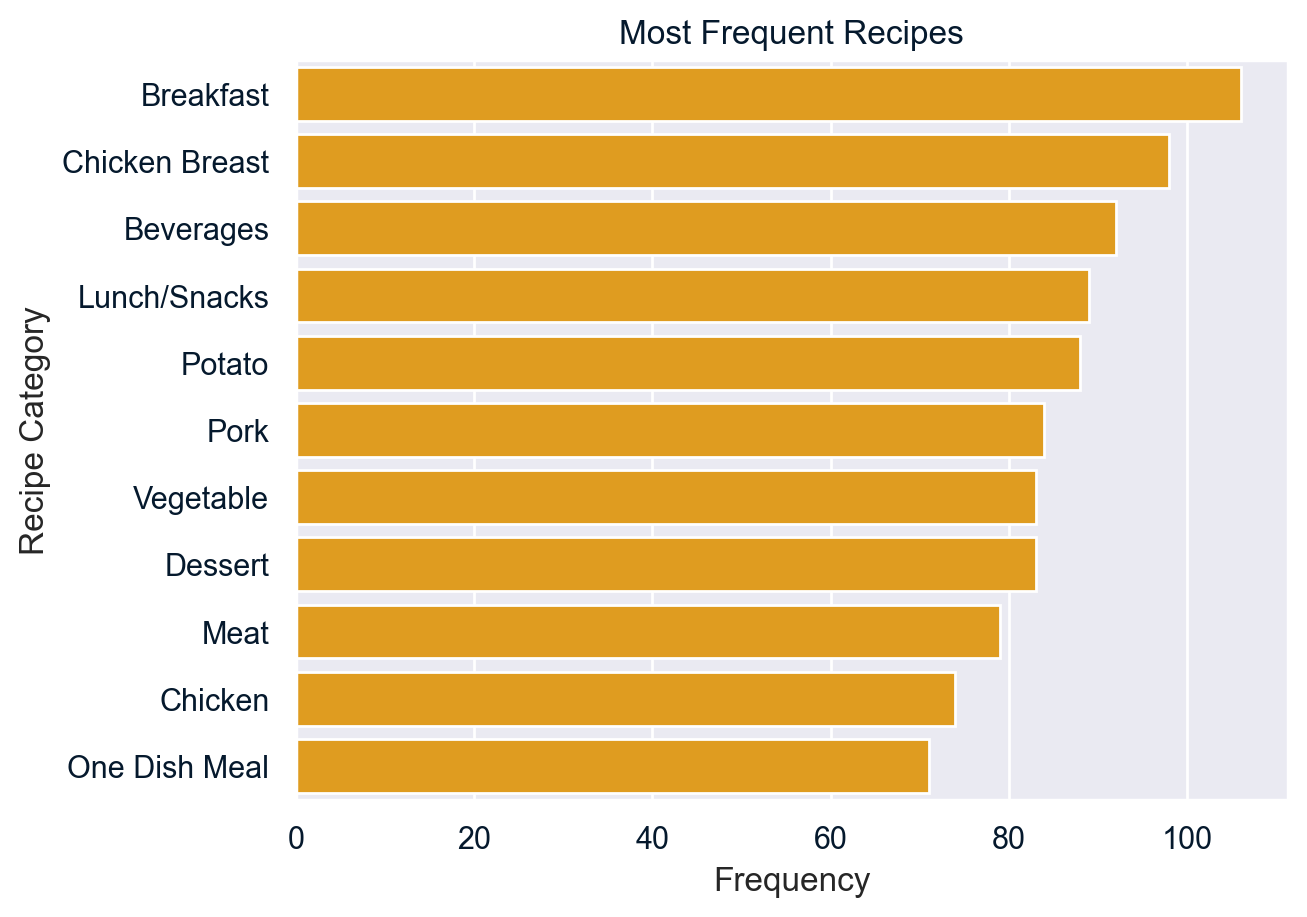

In [100]:
category = df['category'].value_counts().reset_index()
sns.barplot(data=category, x='category', y = 'index', color ='orange')
plt.xlabel('Frequency')
plt.ylabel('Recipe Category')
plt.title('Most Frequent Recipes')
plt.show()

# Observation 05:
1. We post Breakfast, Chicken Breast, Beverages and Lunch/ Snack recipes frequently despite the fact these recipes are not performing well in terms of attracting visitors.

# Business Recommendation 02: 
1. We need to post more recipe's in Potato, Vegetable, Pork, Meat and Lunch/Snacks categories 
## What is the distribution of each numeric column? i-e Calories, Carbohydrates, Sugar and Protein

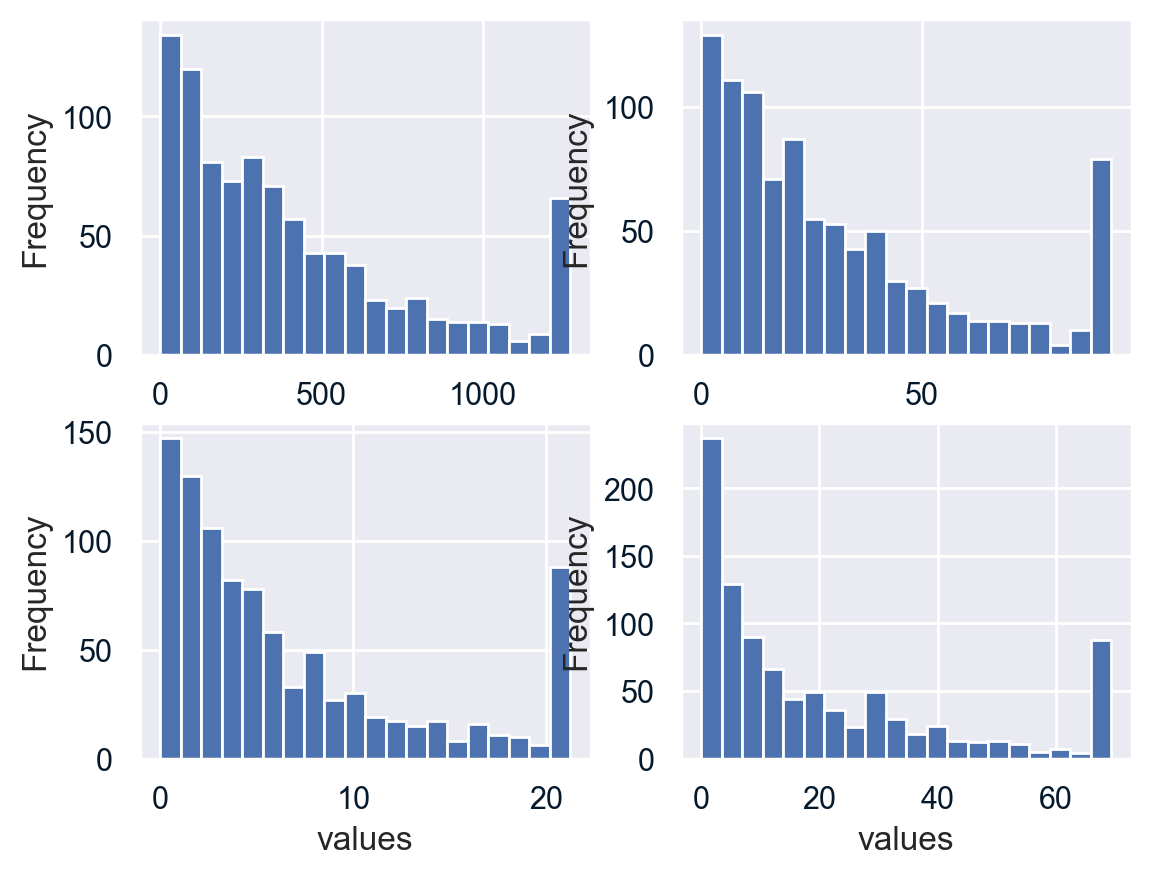

In [101]:
numeric_cols = ['calories', 'carbohydrate', 'sugar', 'protein']
plt.Figure(figsize=(10,5))

for index, column in enumerate(numeric_cols):
    plt.subplot(2, 2, index + 1)
    df[column].hist(bins=20)
    plt.ylabel('Frequency') 
    plt.xlabel('values')
plt.show()

#### What is the average nutritional content (carbohydrate, sugar, protein) by category?

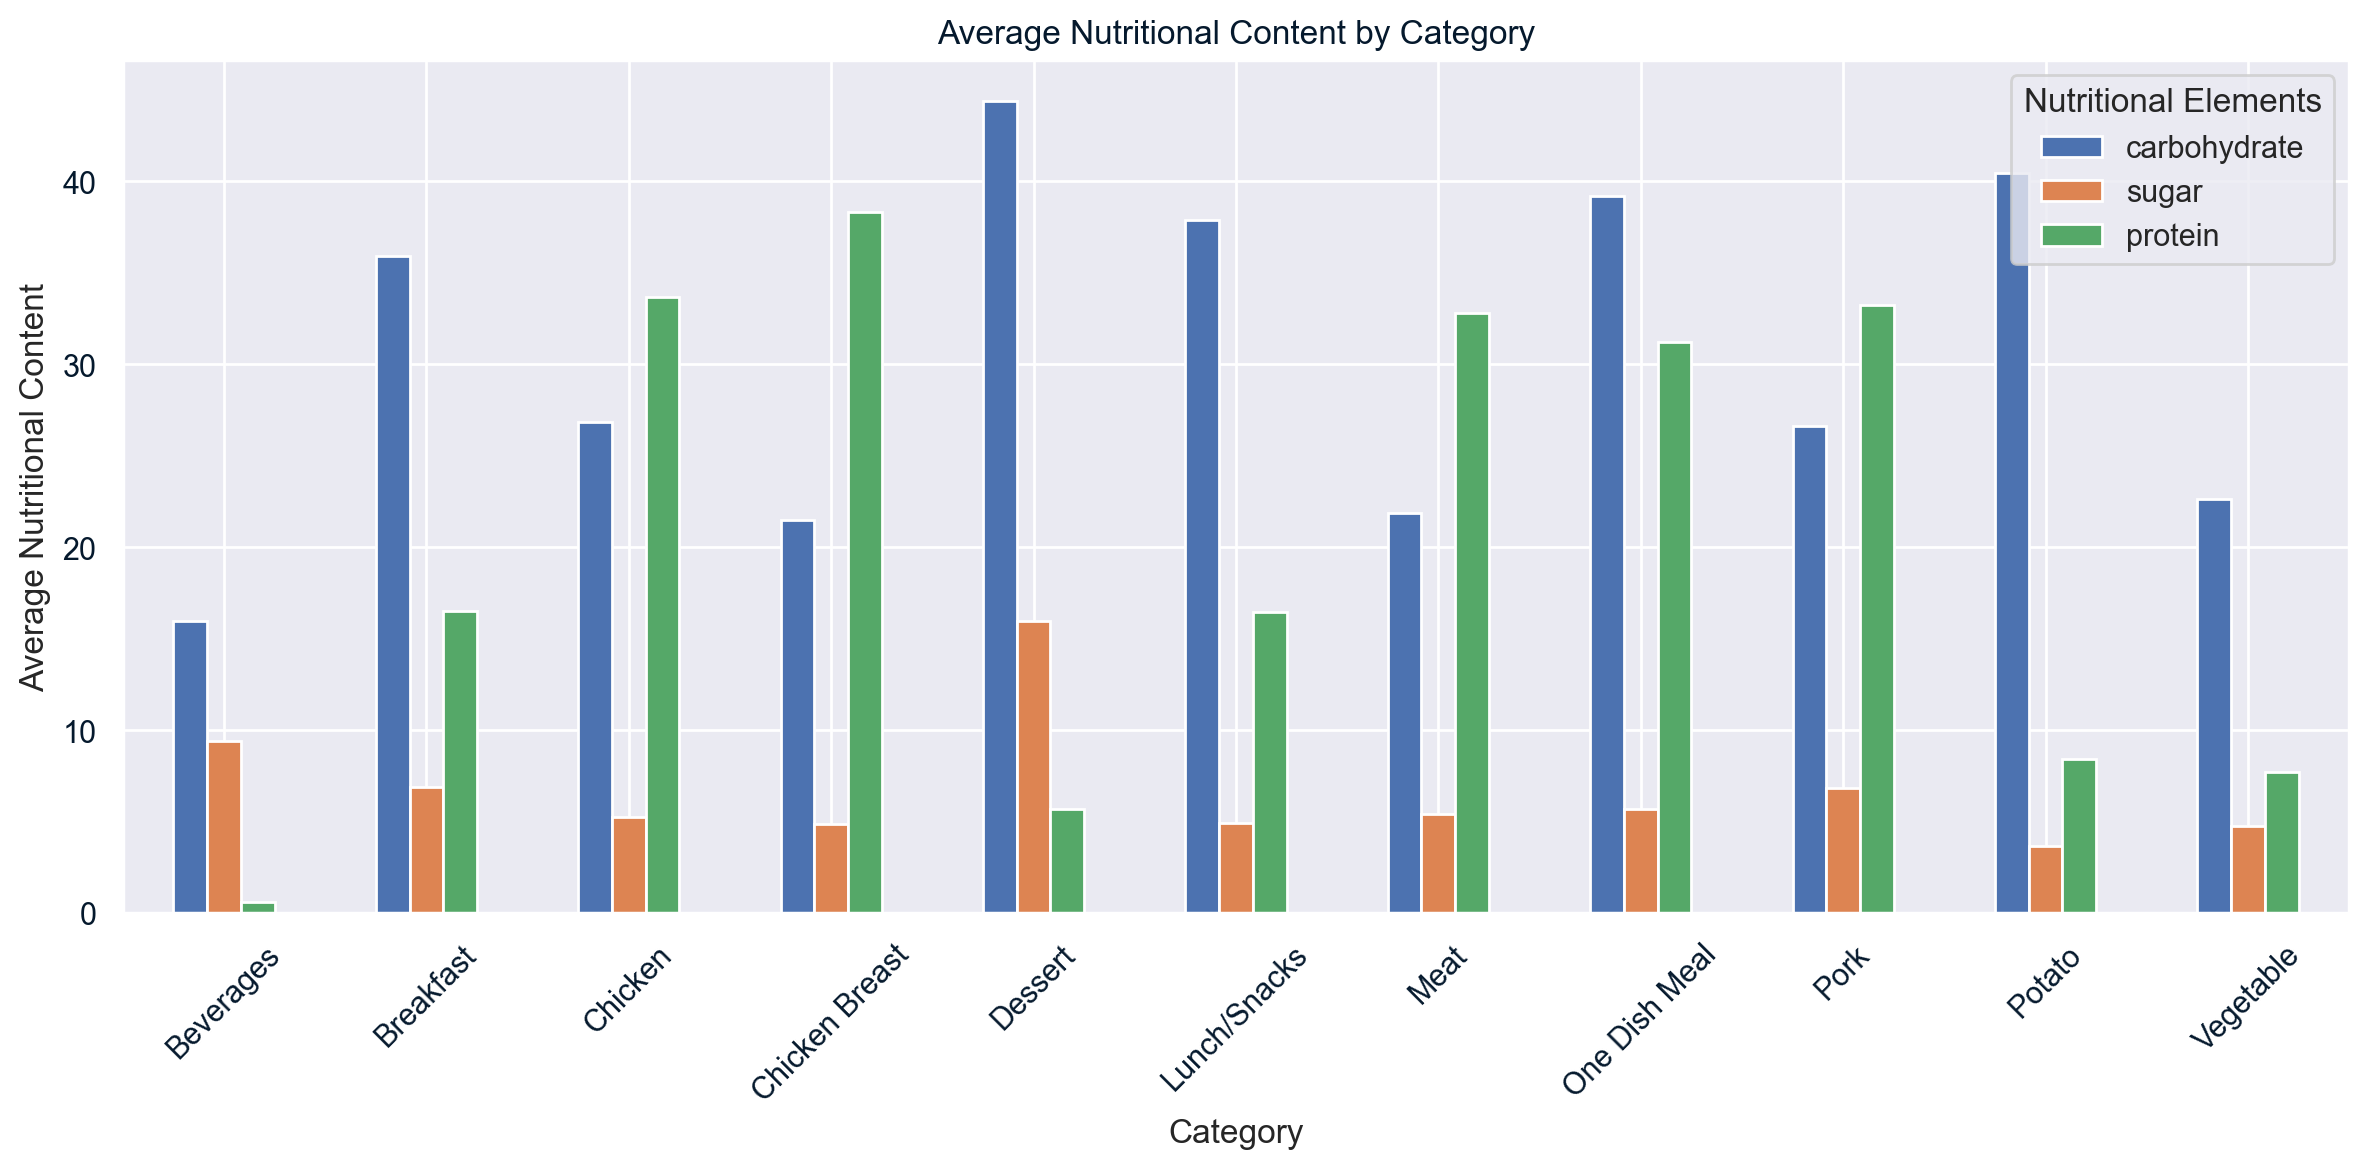

In [102]:
nutritional_content = df.groupby('category')[[ 'carbohydrate', 'sugar', 'protein']].mean().reset_index()
nutritional_content.plot(kind='bar', figsize=(12,6))
plt.xticks(ticks=np.arange(len(nutritional_content)), labels=nutritional_content['category'], rotation=45)
plt.title('Average Nutritional Content by Category')
plt.xlabel('Category')
plt.ylabel('Average Nutritional Content')
plt.xticks(rotation=45)
plt.legend(title='Nutritional Elements')
plt.tight_layout()
plt.show()

# Observation 06:
1. Chicken recipe's have the most amount of protein in them while meat and pork are in the middle and least amount of protein is found in vegetables, desserts and beverages.
2. Potato, desserts and one dish meal are mostly comprised of carbohydrates.
3. Desserts and beverages are the sweetest categories ;)

## What is the distribution of servings for each category?

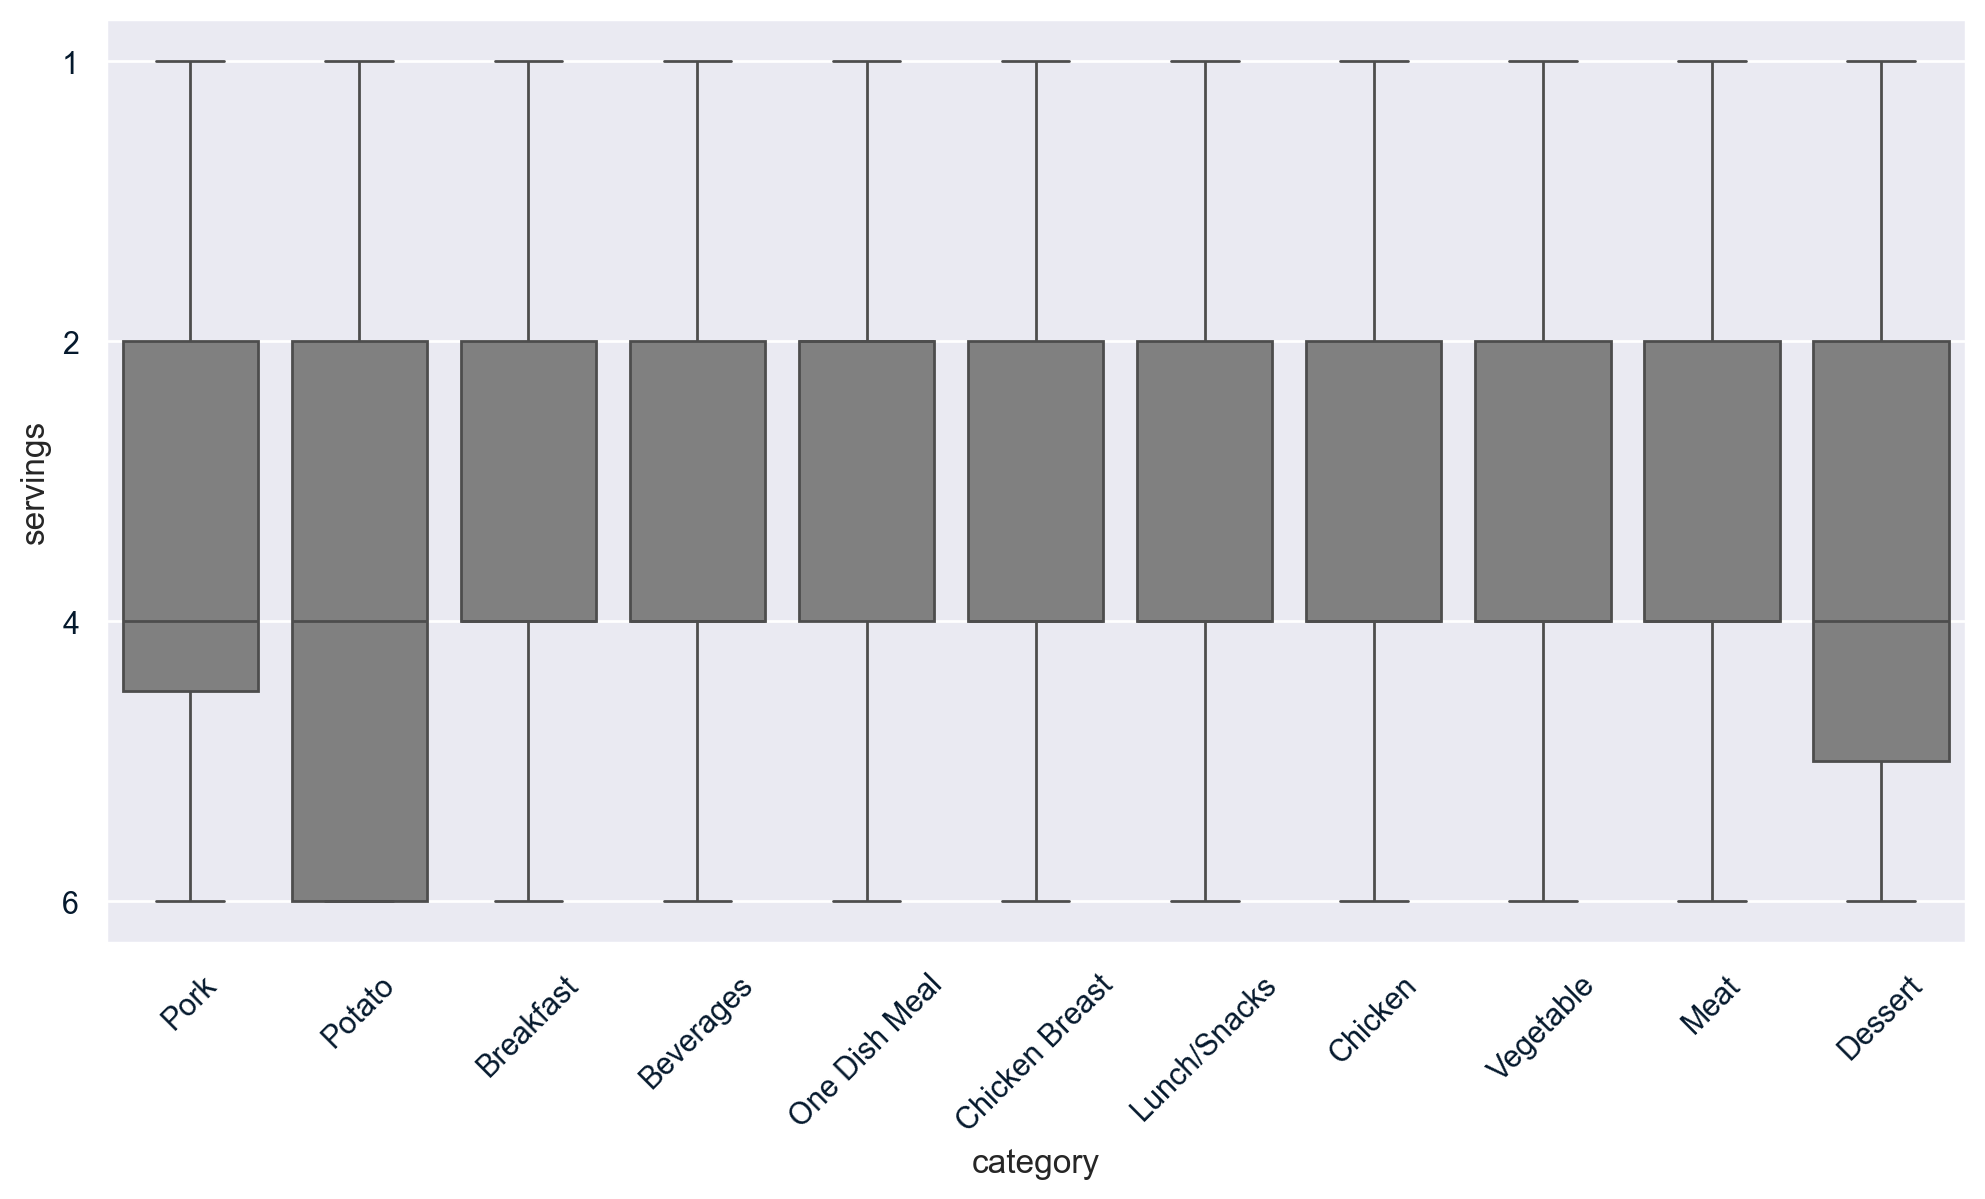

In [103]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='category', y='servings', color = 'grey')
plt.xticks(rotation=45)
plt.show()


#### Are high-calorie recipes more likely to receive high traffic?

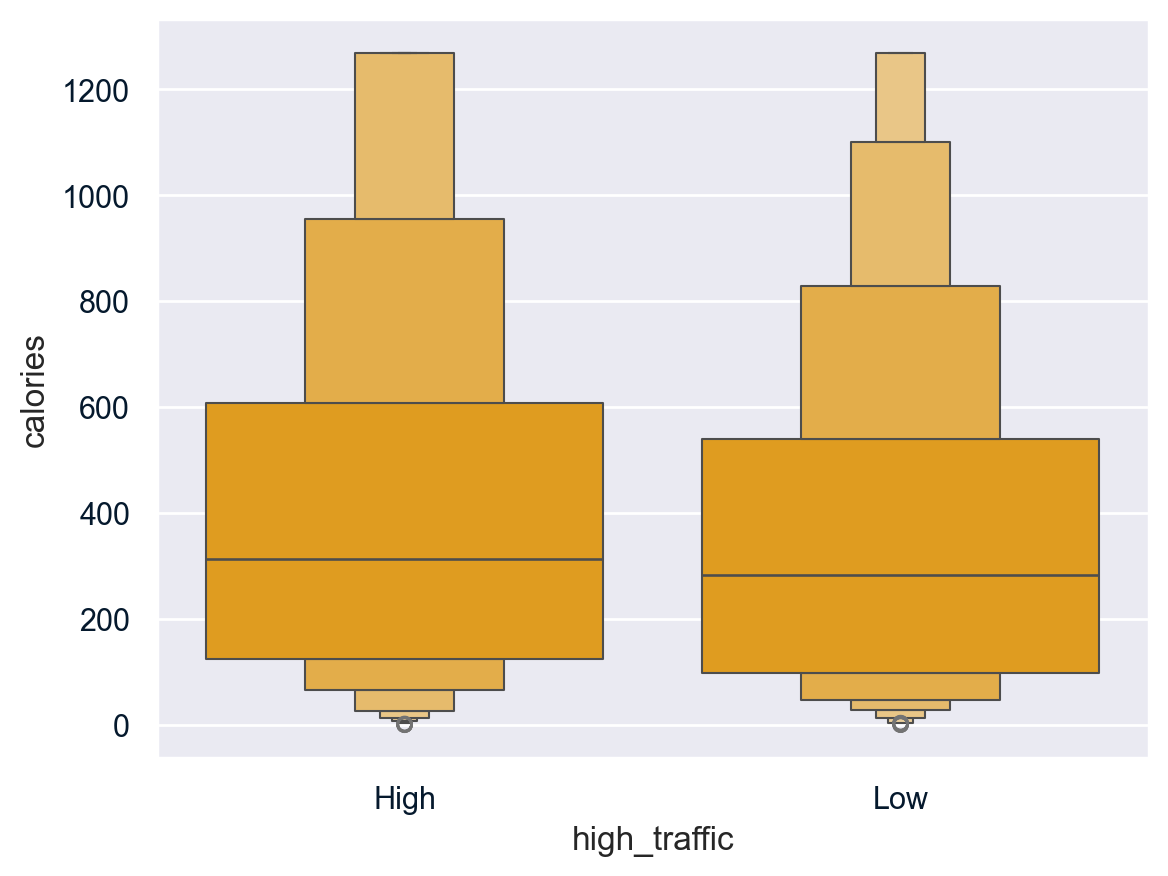

In [104]:
sns.boxenplot(data=df, x='high_traffic', y='calories', color = 'orange')
plt.show()


# Observation 07: 
1. There's a slight difference that the high calorie recipes were more likely to receive high traffic that was because we saw that except potato our popular recipes were Pork, meat and lunch/snacks. It will more evident with the visualization given below.

## Which categories have the highest calorie content on average?

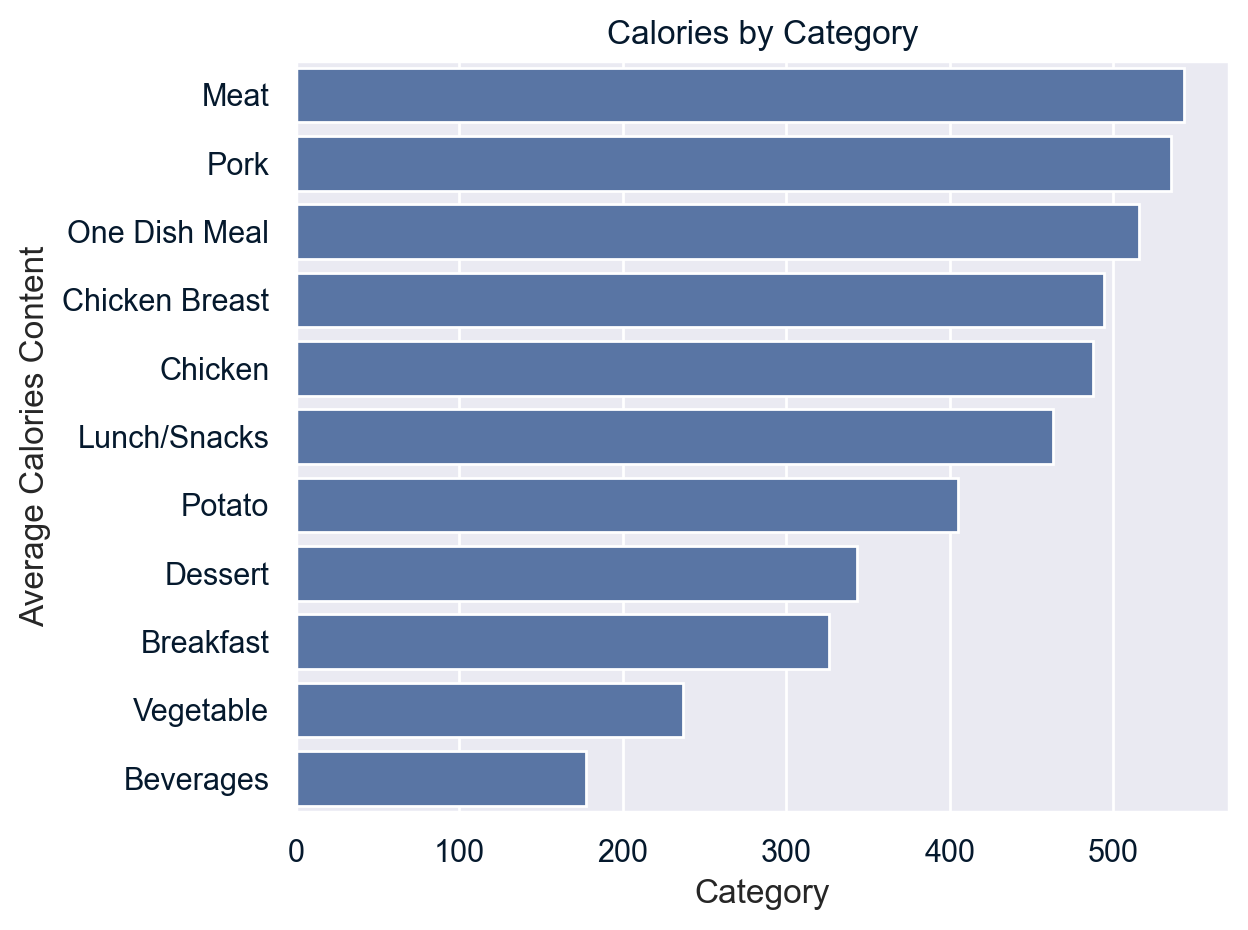

In [105]:
calories_per_category = df.groupby('category')['calories'].mean().sort_values(ascending=False).reset_index()
plt.figsize=(12, 6)
sns.barplot(data = calories_per_category, y= 'category', x = 'calories')
plt.title('Calories by Category')
plt.xlabel('Category')
plt.ylabel('Average Calories Content')
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Are recipes with more protein more likely to be in certain categories?

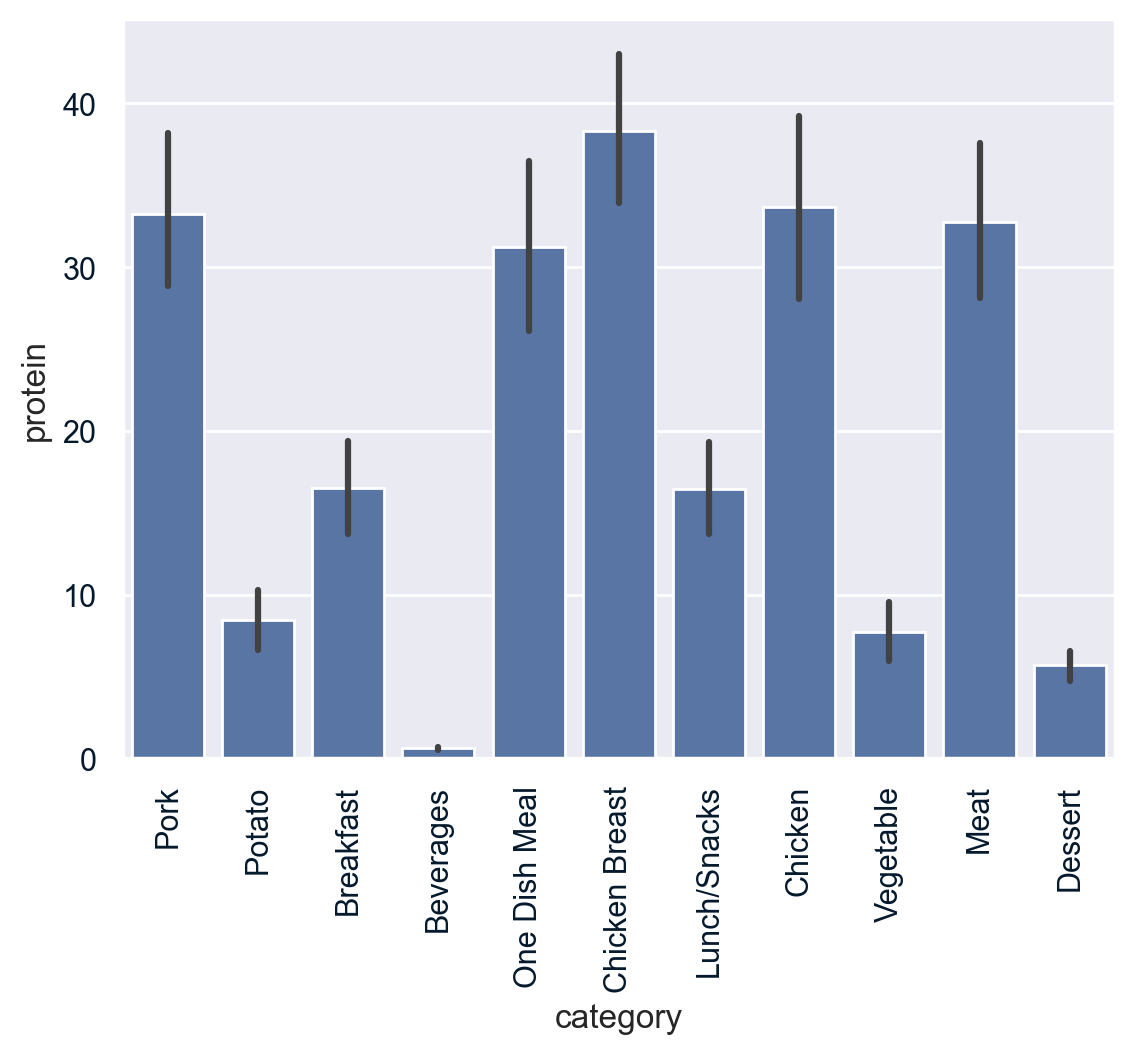

In [106]:
sns.barplot(data=df, x='category', y='protein')
plt.xticks(rotation=90)
plt.show()


## What is the relationship between carbohydrate and sugar content?

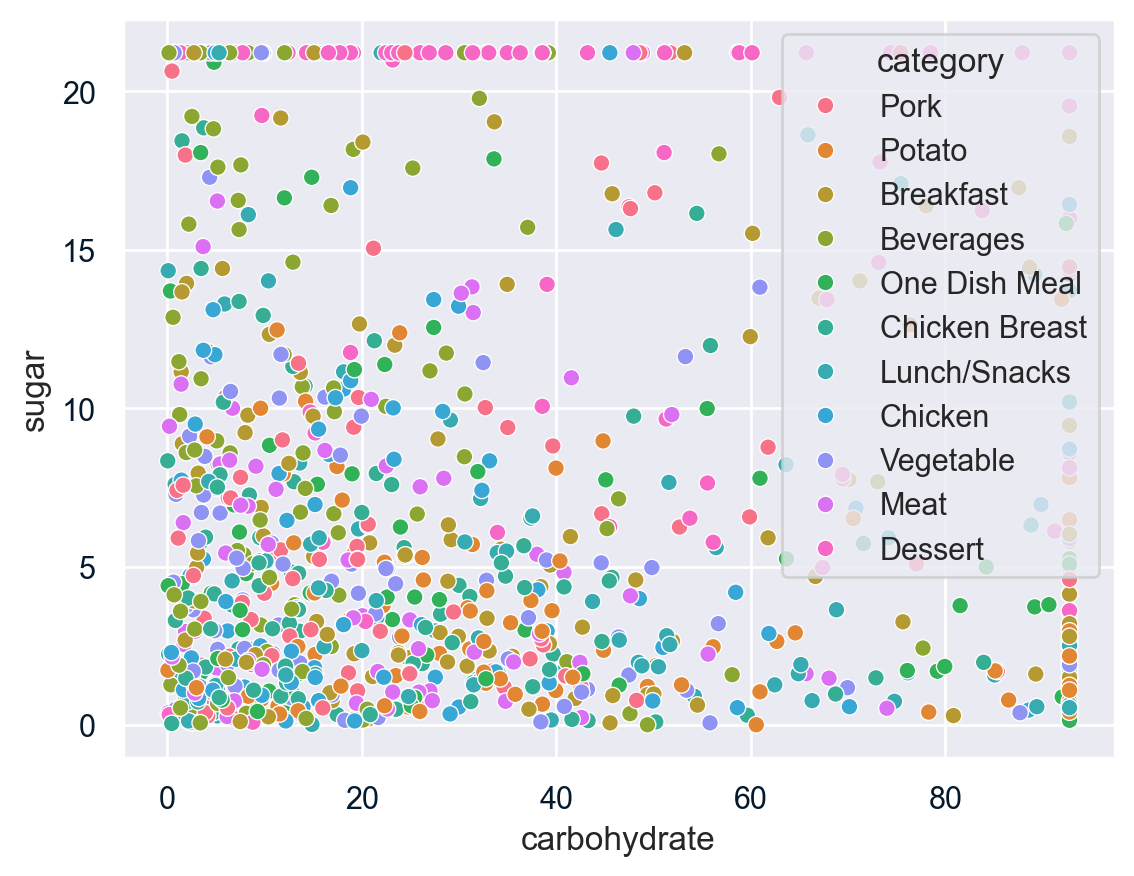

In [107]:
sns.scatterplot(data=df, x='carbohydrate', y='sugar', hue='category')
plt.show()


## Which Categories have the most amount of sugar?

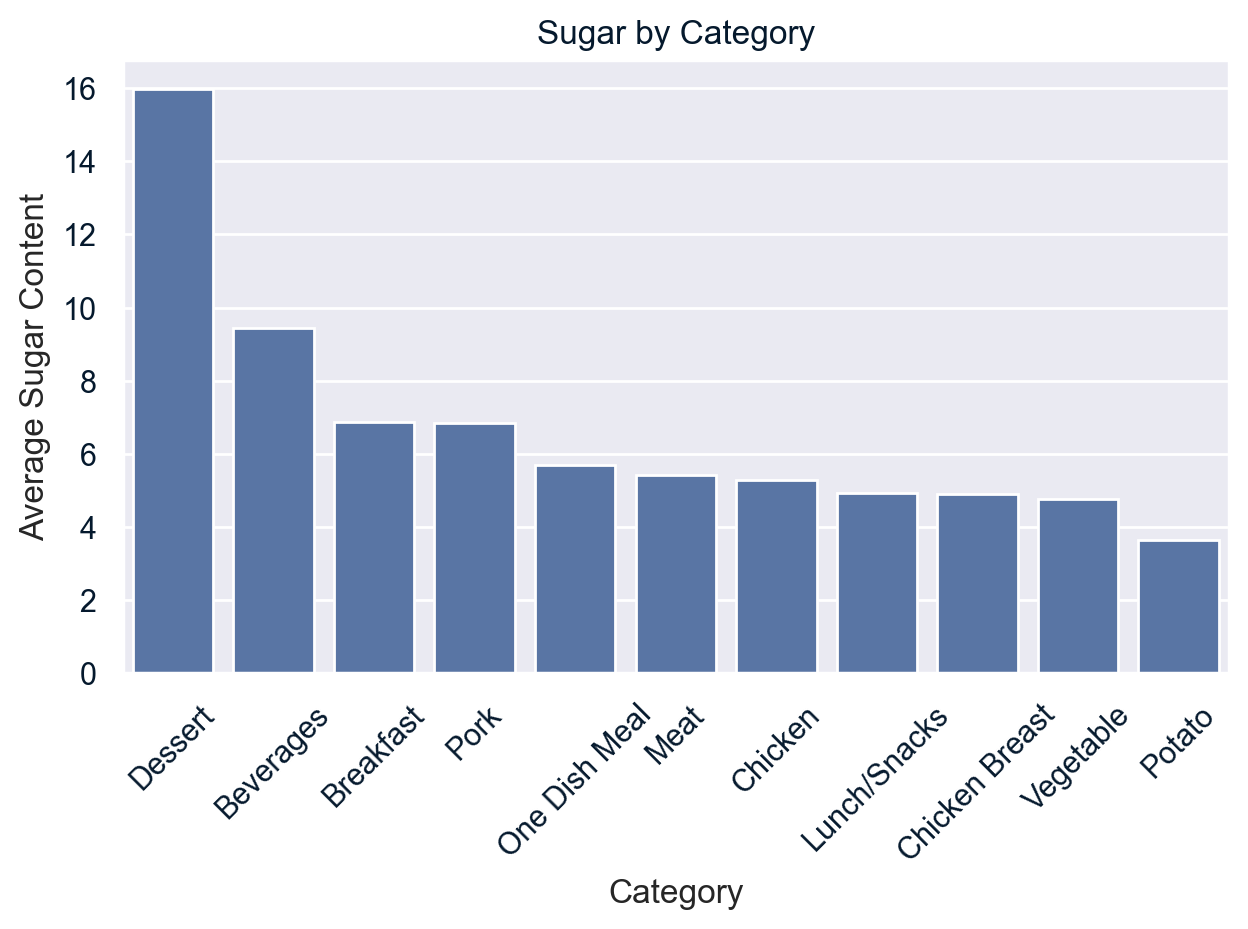

In [108]:
calories_per_category = df.groupby('category')['sugar'].mean().sort_values(ascending=False).reset_index()
plt.figsize=(12, 6)
sns.barplot(data = calories_per_category, x= 'category', y = 'sugar')
plt.title('Sugar by Category')
plt.xlabel('Category')
plt.ylabel('Average Sugar Content')
plt.xticks(rotation=45)
# plt.legend(title='Nutritional Elements')
plt.tight_layout()
plt.show()

## What is the correlation between numeric variables?

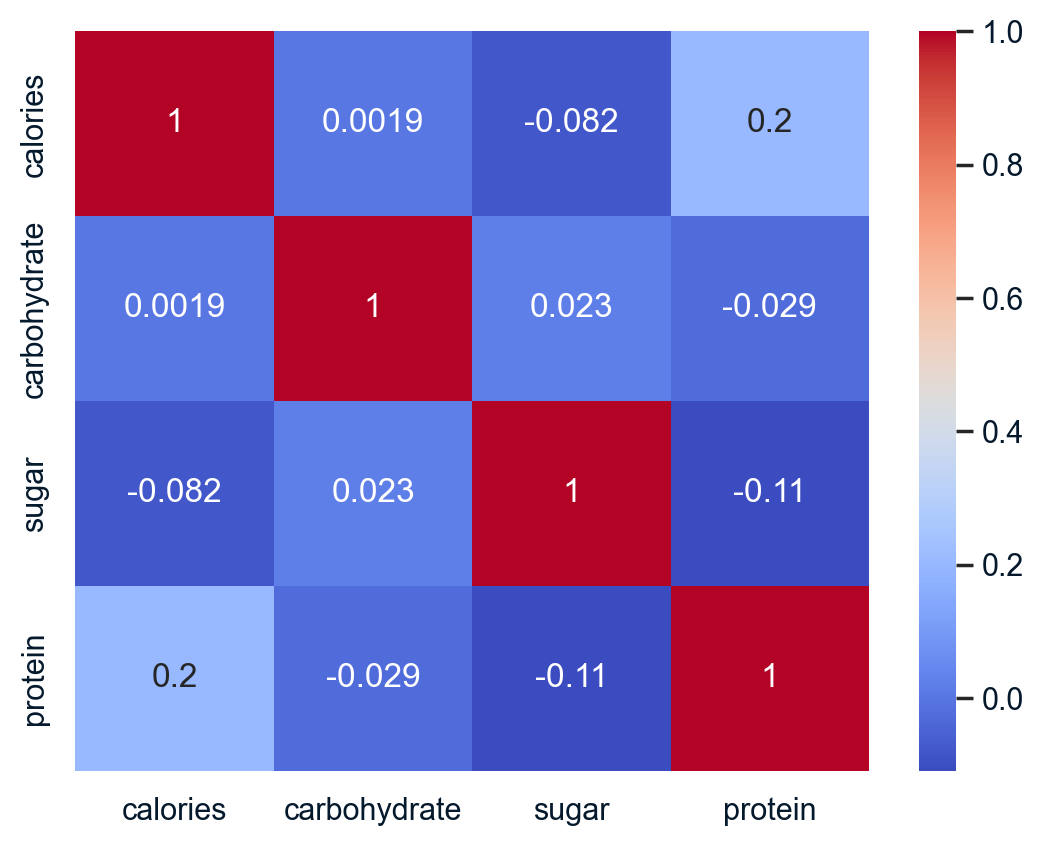

In [109]:
correlation = df[numeric_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()


# Observation 08:
### Weak Correlations: 
1. Most of the correlations between the numerical features (calories, carbohydrate, sugar, protein) are weak.
2. A weak negative correlation exists between calories and protein. This might indicate that recipes with higher protein content tend to have lower calorie counts.

### Positive Correlation: 
1. There is a slight positive correlation between carbohydrate and sugar. This suggests that recipes with higher carbohydrate content tend to have higher sugar content.

# Model Development

## 1. Problem Type
** Since the objective of this task is to find out recipe's that are likely to receive high traffic with 80% accuracy, we can call this a ***Binary Classification Problem*** based on the nutritional and categorical features.
## 2. Baseline Model

Our baseline model will be a logistic regression classifier because:

1. It’s a simple, interpretable model for binary classification.
2. It gives us a good initial benchmark without heavy computation.


In [110]:
# Setting the Seed
SEED = 42
# Convert 'high_traffic' to binary format (0 and 1)
df['high_traffic'] = df['high_traffic'].apply(lambda x: 1 if x == 'High' else 0)

# Scaling the numeric Columns (calories, carbohydrates, sugar, protein)
numeric_columns = ['calories','carbohydrate','sugar','protein']
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(df[numeric_columns])

# Convert the scaled data back to a DataFrame with the original column names
numeric_scaled_df = pd.DataFrame(numeric_scaled, columns=numeric_columns, index=df.index)

# Replace the original columns in the DataFrame with the scaled columns
df[numeric_columns] = numeric_scaled_df

# Apply one hot encoding to the category column
df = pd.get_dummies(df, columns=['category'], drop_first=True)

# Convert the servings column to integer no need to encode because they are alreay discrete numbers
df['servings'] = df['servings'].astype(int)


## Separating Target and Input Features

In [111]:
X = df.drop(columns = ['high_traffic','recipe'], axis = 1)
y = df['high_traffic']

## Splitting the data in 80 / 20 Ratio

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X,
              y, test_size= 0.20, random_state=SEED)
# Verify every input feature and its type
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 757 entries, 109 to 102
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   calories                 757 non-null    float64
 1   carbohydrate             757 non-null    float64
 2   sugar                    757 non-null    float64
 3   protein                  757 non-null    float64
 4   servings                 757 non-null    int64  
 5   category_Breakfast       757 non-null    uint8  
 6   category_Chicken         757 non-null    uint8  
 7   category_Chicken Breast  757 non-null    uint8  
 8   category_Dessert         757 non-null    uint8  
 9   category_Lunch/Snacks    757 non-null    uint8  
 10  category_Meat            757 non-null    uint8  
 11  category_One Dish Meal   757 non-null    uint8  
 12  category_Pork            757 non-null    uint8  
 13  category_Potato          757 non-null    uint8  
 14  category_Vegetable      

## Fitting the base model (Logistic Regression)

1. Hyperparameter Tuned
2. Scaled Features
3. Balanced Class weights

              precision    recall  f1-score   support

           0       0.71      0.71      0.71        77
           1       0.80      0.80      0.80       113

    accuracy                           0.76       190
   macro avg       0.75      0.76      0.75       190
weighted avg       0.76      0.76      0.76       190



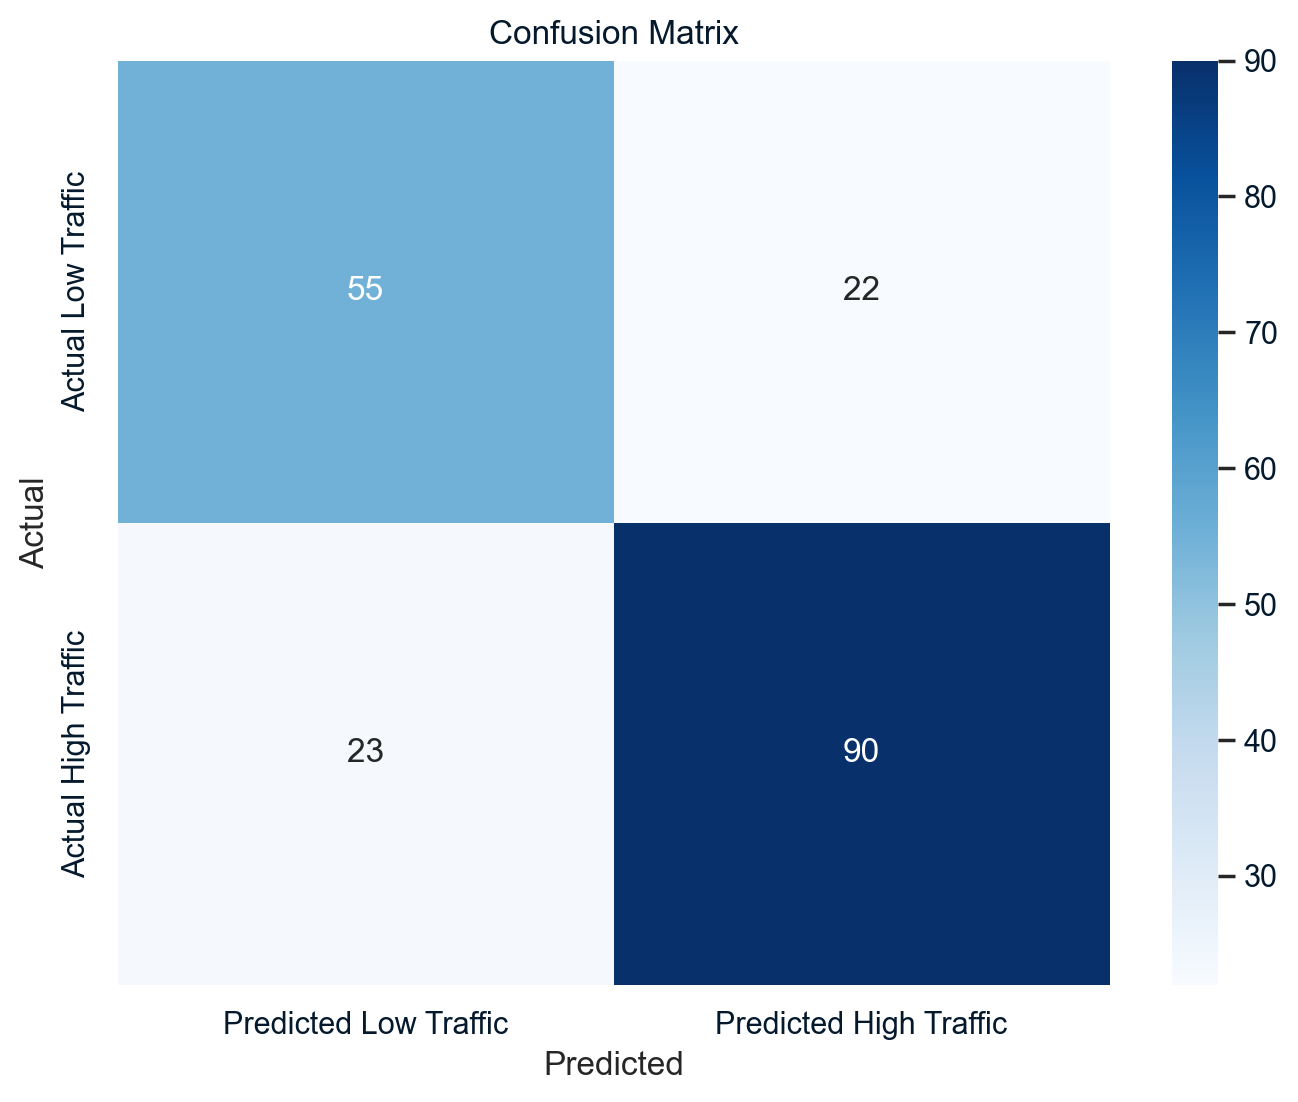

In [113]:
# logistic regression modeling
model = LogisticRegression(random_state=SEED, class_weight='balanced')
model.fit(X_train, y_train)

#tuning parameters
param_grid = {'C': [0.1, 1, 10, 100],
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear', 'saga']
              }

grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(X_train, y_train)

# make predictions
y_pred = grid.predict(X_test)

# make classification report
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test,y_pred)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Low Traffic', 'Predicted High Traffic'], yticklabels=['Actual Low Traffic', 'Actual High Traffic'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

## Feature Importance:

1. Evaluate which features are contributing the most for predicting the high traffic recipes

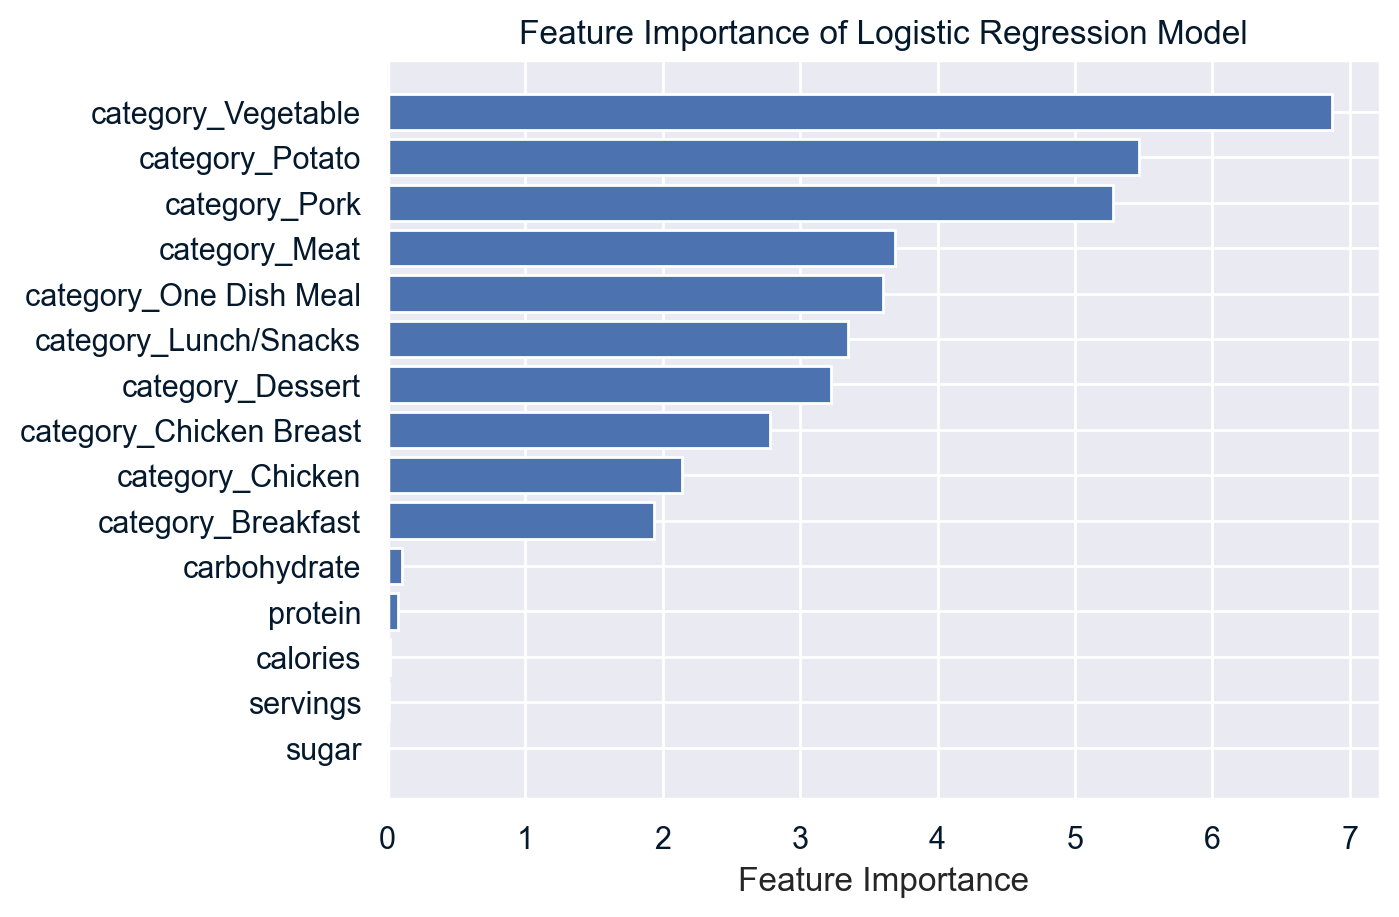

In [114]:
# Get the best model
best_model = grid.best_estimator_

# Extract feature importance
feature_importance = np.abs(best_model.coef_[0])

# Sort feature importance in descending order
feature_importance = sorted(zip(X_train.columns, feature_importance), key=lambda x: x[1], reverse=False)

# visualize the feature importance of baseline Logistic Regression Model:
plt.barh(range(len(feature_importance)), [x[1] for x in feature_importance])
plt.yticks(range(len(feature_importance)), [x[0] for x in feature_importance])
plt.xlabel("Feature Importance")
plt.title("Feature Importance of Logistic Regression Model")
plt.show()

# Observation 09:
1. Achieved 76% model accuracy with predictions
2. Most contributing feature for prediction is proved to be Category and popular categories are Vegetable, Potato, Pork.
3. Numeric features like calories, servings, protein, sugar, and carbohydrate have relatively lower importance.

# Business Recommendation 03: 
1. Feature more recipes around potato, vegetable and pork on the home page.

# Model Comparison Strategy:
1. Tried with couple of other classification models like random forest and XGboost but they were proven to less accurate.
2. Therefore decided to mplemente 6 models including hyper tuned logistic regression to see how they compare to each other interms of accuracy.

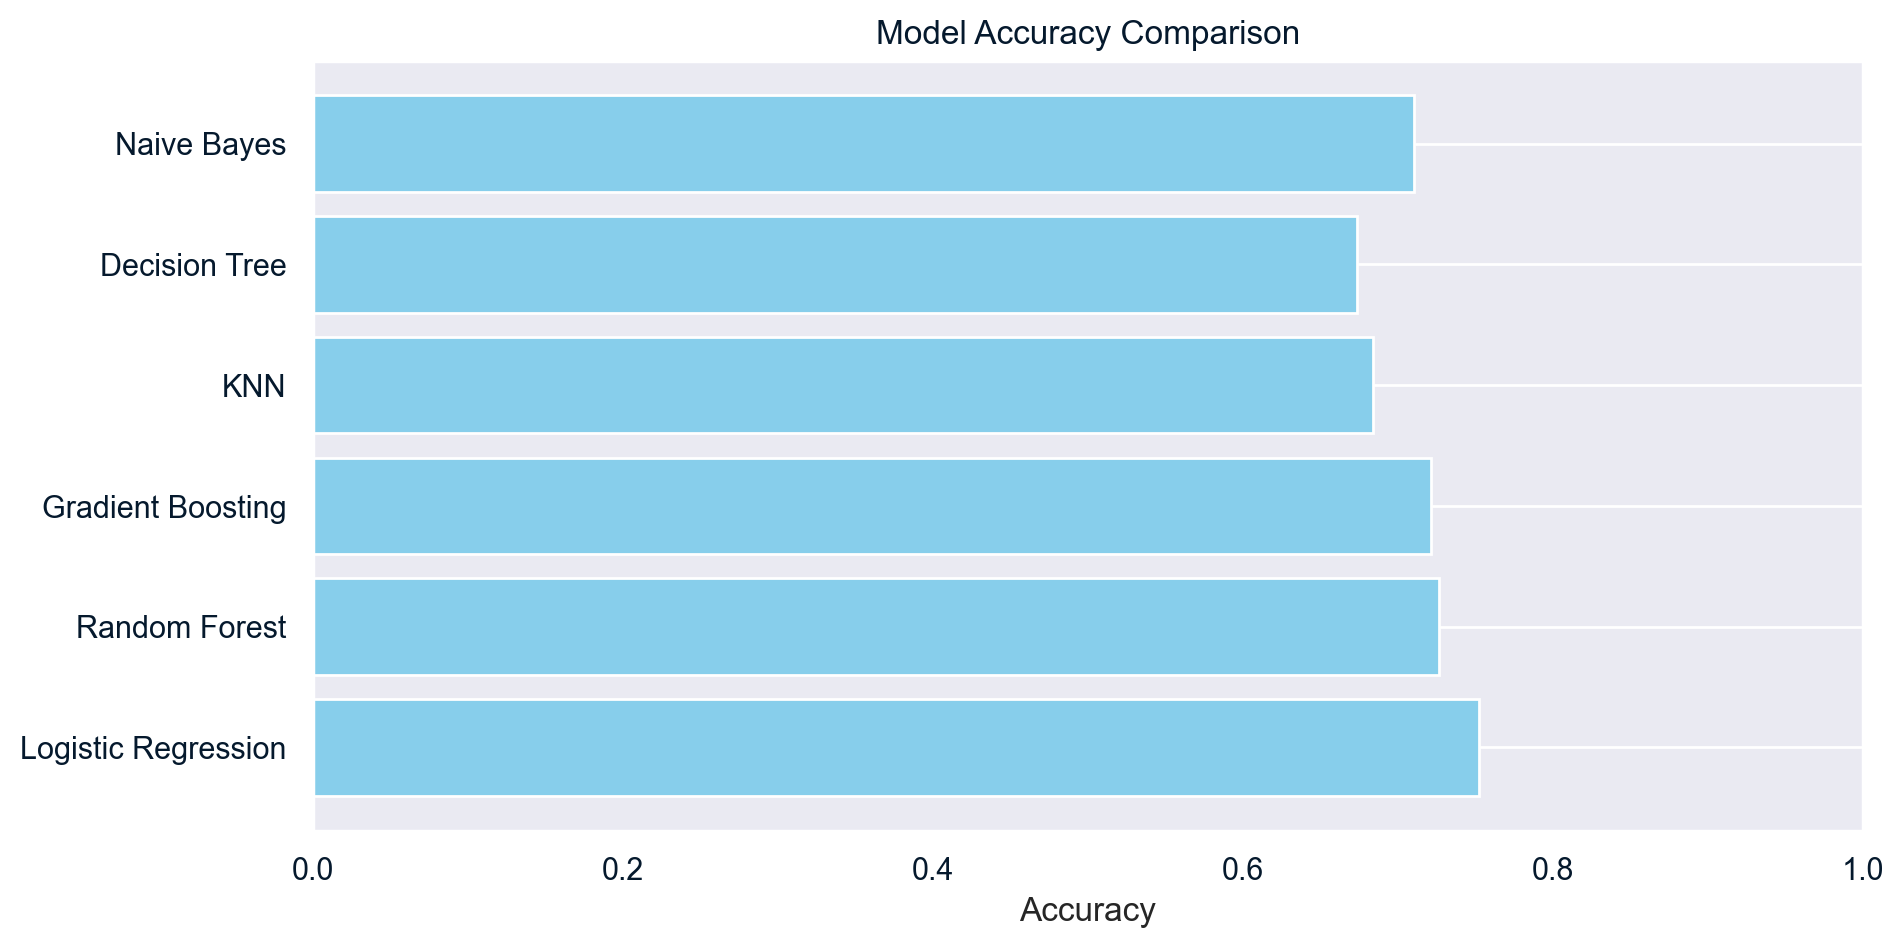

In [115]:
def test_algorithms(df, target_column):
    """
    Test multiple algorithms and plot their accuracies.

    Parameters:
        df (pd.DataFrame): The input DataFrame with features and target.
        target_column (str): The name of the target column.

    Returns:
        None: Plots accuracies of different algorithms.
    """
    # Initialize models
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(),
        "Gradient Boosting": GradientBoostingClassifier(),
        "KNN": KNeighborsClassifier(),
        "Decision Tree": DecisionTreeClassifier(),
        "Naive Bayes": GaussianNB()
    }
    
    # Define hyperparameter grids for tuning
    param_grids = {
        "Logistic Regression": {
            'C': [0.01, 0.1, 1, 10, 100],
            'solver': ['liblinear', 'saga']
        },
        "Random Forest": {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        },
        "Naive Bayes": {
            'var_smoothing': [1e-9, 1e-8, 1e-7]
        }
    }
    
    accuracies = {}
    
    # Train and evaluate each model with hyperparameter tuning for specified models
    for model_name, model in models.items():
        if model_name in param_grids:
            grid_search = GridSearchCV(model, param_grids[model_name], cv=5, n_jobs=-1)
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        accuracies[model_name] = accuracy
    
    # Plotting accuracies
    plt.figure(figsize=(10, 5))
    plt.barh(list(accuracies.keys()), list(accuracies.values()), color='skyblue')
    plt.xlabel('Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.xlim(0, 1)  # Set x-axis limit to 0-1 for better visibility
    plt.grid(axis='x')
    plt.show()

# Testing algorithms with 'high_traffic' as target variable 
test_algorithms(df, 'high_traffic')

# Observation 10:

1. The best performing model is still Logistic Regression and followed by Gradient Boosting and KNN but since it is not as accurate as Logistic regression I will rather pick it over both.

# Business Metric:

## Definition:

High-Traffic Recipe Rate (HTRR): Percentage of recipes classified as high-traffic.

## Initial Value for (HTRR) = 60.61% 

In [116]:
traffic_conversion_rate = df['high_traffic'].value_counts(normalize = True)[1] * 100
print(f"High Traffic Recipe Rate: {traffic_conversion_rate:.2f}%")


High Traffic Recipe Rate: 60.61%


## Monitoring the Metric:

1. Regular Tracking: Monthly calculate and track the rate.
2. A/B Testing: Experiment with different recipe categories or recommendations.

## Monitoring Approach

1. Monthly Reports: Track the percentage of recipes predicted to receive high traffic for each category and compare with the actual observed traffic.
2. Category Trends: Present a trend analysis of the categories that consistently attract high traffic based on model predictions versus actuals. This can help identify seasonal or category-specific patterns.

# Final Summary:

Based on the logistic regression model, we can currently predict high-traffic recipes with 76% accuracy. Categories like Potato,Vegetable and Pork are more frequently identified as high-traffic and tend to perform well based on observed data. I recommend that leveraging these categories more in marketing and site feature strategies.

Recommendation: Focus on enhancing recipe content and visibility for high-performing categories. Stay upto date with 'High Traffic Recipe Rate' indicator atleast monthly assuming its itital value (60.61%) as minimum threshold. We can aim to increase it by posting the recipes in the recommended categories.

## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation